# IPF - Raking data

This Notebook contains the code I used to perform and Evaluate the IPF sections from my Master Thesis Project : **Bayesian Inference for Geospatial Network Models of Large-scale Social Networks**.

The code is divided in the sequential steps I follow through my research. The last group of cell  (Transition Matrix) is drafts of techniques I explored to recover time and spatial data though Bayesian Hierarchichal Modeling. I ended up not usng them in my research but feel free to contribute to this part and notify me if you follow through this part.

_Note_ : it requires the imports of numpyro jax and arviz that do not figure in this notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from scipy.optimize import minimize
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from scipy.special import rel_entr


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [ ]:
age_stat = pd.read_csv('/content/drive/MyDrive/RESEARCH/age_stat_nuts3_01.csv')
sex_edu_stat = pd.read_csv('/content/drive/MyDrive/RESEARCH/sex_edu_stat_nuts3_01.csv')
sex_edu_ind = pd.read_csv('/content/drive/MyDrive/RESEARCH/sex_edu_ind_nuts3_01.csv')

In [ ]:
age_stat.drop(columns=['DATAFLOW','LAST UPDATE', 'freq','unit','TIME_PERIOD','OBS_FLAG','CONF_STATUS'], inplace=True)
sex_edu_stat.drop(columns=['DATAFLOW','LAST UPDATE', 'freq','unit','TIME_PERIOD','OBS_FLAG','CONF_STATUS'], inplace=True)
sex_edu_ind.drop(columns=['DATAFLOW','LAST UPDATE', 'freq','unit','TIME_PERIOD','OBS_FLAG','CONF_STATUS'], inplace=True)


In [ ]:
print(age_stat.columns)
print(sex_edu_ind.columns)
print(sex_edu_stat.columns)

Index(['wstatus', 'age', 'sex', 'geo', 'OBS_VALUE'], dtype='object')
Index(['isco88', 'isced97', 'age', 'sex', 'geo', 'OBS_VALUE'], dtype='object')
Index(['wstatus', 'isced97', 'age', 'sex', 'geo', 'OBS_VALUE'], dtype='object')


### Map dictionnary values

In [ ]:
age_group_map = {
    'Less than 15 years': 'YLT15',
    'From 15 to 19 years': 'Y15-29',
    'From 20 to 24 years': 'Y15-29',
    'From 25 to 29 years': 'Y15-29',
    'From 30 to 34 years': 'Y30-49',
    'From 35 to 39 years': 'Y30-49',
    'From 40 to 44 years': 'Y30-49',
    'From 45 to 49 years': 'Y30-49',
    'From 50 to 54 years': 'Y50-64',
    'From 55 to 59 years': 'Y50-64',
    'From 60 to 64 years': 'Y50-64',
    'From 65 to 69 years': 'Y65-84',
    'From 70 to 74 years': 'Y65-84',
    '75 years or over': 'YGE85',
    'Unknown': 'UNK'
}


age_stat['age_group'] = age_stat['age'].map(age_group_map)

In [ ]:
level_to_isced97 = {
    'No education': 'ISCED97_X',
    'Pre-primary and primary education (levels 0 and 1)': 'ISCED97_0_1',
    'Primary education or first stage of basic education (level 1)': 'ISCED97_1',
    'Lower secondary or second stage of basic education (level 2)': 'ISCED97_2',
    'Upper secondary education (level 3)': 'ISCED97_3',
    'Post-secondary non-tertiary education (level 4)': 'ISCED97_4',
    'First and second stage of tertiary education (levels 5 and 6)': 'ISCED97_5_6',
    'Unknown': 'ISCED97_9',
    'Total of all level ISCED97 and no education': 'ISCED97_TOTAL'
}

sex_edu_stat['level'] = sex_edu_stat['isced97'].map(level_to_isced97)
sex_edu_ind['level'] = sex_edu_ind['isced97'].map(level_to_isced97)

In [ ]:
isced97_to_isced2011_mapping = {
    'ISCED97_0': ['ISCED_02'],
    'ISCED97_1': ['ISCED_1'],
    'ISCED97_2': ['ISCED_2'],
    'ISCED97_3': ['ISCED_3'],
    'ISCED97_4': ['ISCED_4'],
    'ISCED97_5_6': ['ISCED_6', 'ISCED_7', 'ISCED_5'],  # à répartir avec proba
    'ISCED97_X': ['ISCED_X'],
    'ISCED97_9': ['ISCED_9'],
    'ISCED97_TOTAL': ['ISCED_TOTAL'],
    'ISCED97_0_1': ['ISCED_02', 'ISCED_1'],  # 50/50
}

def map_isced97_to_isced2011(row):
    isced = row['level']
    value = row['OBS_VALUE']

    if isced == 'ISCED97_0_1':
        return pd.DataFrame({'ISCED2011': ['ISCED_02', 'ISCED_1'], 'OBS_VALUE': [value/2, value/2]})
    elif isced == 'ISCED97_5_6':
        # Répartition : 55% Bachelor, 30% Master, 15% Short-cycle
        probs = [0.55, 0.30, 0.15]
        isced2011 = ['ISCED_6', 'ISCED_7', 'ISCED_5']
        return pd.DataFrame({'ISCED2011': isced2011, 'OBS_VALUE': [p * value for p in probs]})
    else:
        mapped = isced97_to_isced2011_mapping.get(isced, ['ISCED_UNKNOWN'])
        return pd.DataFrame({'ISCED2011': mapped, 'OBS_VALUE': [value] })

# Application au DataFrame sex_edu_stat
expanded_rows_stat = []
for _, row in sex_edu_stat.iterrows():
    df = map_isced97_to_isced2011(row)
    for _, new_row in df.iterrows():
        new = row.copy()
        new['ISCED2011'] = new_row['ISCED2011']
        new['OBS_VALUE'] = new_row['OBS_VALUE']
        expanded_rows_stat.append(new)

sex_edu_stat_2011 = pd.DataFrame(expanded_rows_stat)

# Idem pour sex_edu_ind
expanded_rows_ind = []
for _, row in sex_edu_ind.iterrows():
    df = map_isced97_to_isced2011(row)
    for _, new_row in df.iterrows():
        new = row.copy()
        new['ISCED2011'] = new_row['ISCED2011']
        new['OBS_VALUE'] = new_row['OBS_VALUE']
        expanded_rows_ind.append(new)

sex_edu_ind_2011 = pd.DataFrame(expanded_rows_ind)


In [ ]:
sex_edu_ind_2011['OBS_VALUE'].unique()

array([5.0000e-01, 1.5000e+00, 0.0000e+00, ..., 2.2030e+03, 8.9480e+03,
       1.8688e+04])

In [ ]:
occupation_to_sector = {
    'Armed forces': 'O-U',
    'Legislators, senior officials and managers': 'K-N',
    'Professionals': 'K-N',
    'Technicians and associate professionals': 'G-J',
    'Clerks': 'K-N',
    'Service workers and shop and market sales workers': 'G-I',
    'Skilled agricultural and fishery workers': 'A',
    'Craft and related trades workers': 'C',
    'Plant and machine operators and assemblers': 'C',
    'Elementary occupations': 'R-U',
    'Total': '',
    'Unknown': ''
}

sex_edu_ind_2011['sector'] = sex_edu_ind_2011['isco88'].map(occupation_to_sector)


In [ ]:
sex_edu_ind_2011

,isco88,isced97,age,sex,geo,OBS_VALUE,level,ISCED2011,sector
0,Armed forces,Pre-primary and primary education (levels 0 an...,Total,Females,Dobrich (statistical region 2005),0.5,ISCED97_0_1,ISCED_02,O-U
0,Armed forces,Pre-primary and primary education (levels 0 an...,Total,Females,Dobrich (statistical region 2005),0.5,ISCED97_0_1,ISCED_1,O-U
1,Armed forces,Pre-primary and primary education (levels 0 an...,Total,Females,Vaud,0.5,ISCED97_0_1,ISCED_02,O-U
1,Armed forces,Pre-primary and primary education (levels 0 an...,Total,Females,Vaud,0.5,ISCED97_0_1,ISCED_1,O-U
2,Armed forces,Pre-primary and primary education (levels 0 an...,Total,Females,Bern / Berne,0.5,ISCED97_0_1,ISCED_02,O-U
...,...,...,...,...,...,...,...,...,...
106825,Unknown,Unknown,Total,Males,Elbląski,1.0,ISCED97_9,ISCED_9,
106826,Unknown,Unknown,Total,Males,Olsztyński,2.0,ISCED97_9,ISCED_9,
106827,Unknown,Unknown,Total,Males,Slupski (NUTS 2010),15.0,ISCED97_9,ISCED_9,
106828,Unknown,Unknown,Total,Males,Gdanski (NUTS 2003),16.0,ISCED97_9,ISCED_9,


## IPF with regional constraints


### Data Preparation

In [ ]:
df_ast_r = pd.read_csv('/content/drive/MyDrive/RESEARCH/age_stat_nuts3_01.csv')
df_sest_r = pd.read_csv('/content/drive/MyDrive/RESEARCH/sex_edu_stat_nuts3_01.csv')
df_sei_r = pd.read_csv('/content/drive/MyDrive/RESEARCH/sex_edu_ind_nuts3_01.csv')

df_ast_r.drop(columns=['DATAFLOW','LAST UPDATE', 'freq','unit','TIME_PERIOD','OBS_FLAG','CONF_STATUS'], inplace=True)
df_sei_r.drop(columns=['DATAFLOW','LAST UPDATE', 'freq','unit','TIME_PERIOD','OBS_FLAG','CONF_STATUS'], inplace=True)
df_sest_r.drop(columns=['DATAFLOW','LAST UPDATE', 'freq','unit','TIME_PERIOD','OBS_FLAG','CONF_STATUS'], inplace=True)

age_group_map = {
    'Less than 15 years': 'YLT15',
    'From 15 to 19 years': 'Y15-29',
    'From 20 to 24 years': 'Y15-29',
    'From 25 to 29 years': 'Y15-29',
    'From 30 to 34 years': 'Y30-49',
    'From 35 to 39 years': 'Y30-49',
    'From 40 to 44 years': 'Y30-49',
    'From 45 to 49 years': 'Y30-49',
    'From 50 to 54 years': 'Y50-64',
    'From 55 to 59 years': 'Y50-64',
    'From 60 to 64 years': 'Y50-64',
    'From 65 to 69 years': 'Y65-84',
    'From 70 to 74 years': 'Y65-84',
    '75 years or over': 'YGE85',
    'Unknown': 'UNK'
}


df_ast_r['AGE'] = df_ast_r['age'].map(age_group_map)
df_ast_r = df_ast_r.drop(columns=['age'])

level_to_isced97 = {
    'No education': 'ISCED97_X',
    'Pre-primary and primary education (levels 0 and 1)': 'ISCED97_0_1',
    'Primary education or first stage of basic education (level 1)': 'ISCED97_1',
    'Lower secondary or second stage of basic education (level 2)': 'ISCED97_2',
    'Upper secondary education (level 3)': 'ISCED97_3',
    'Post-secondary non-tertiary education (level 4)': 'ISCED97_4',
    'First and second stage of tertiary education (levels 5 and 6)': 'ISCED97_5_6',
    'Unknown': 'ISCED97_9',
    'Total of all level ISCED97 and no education': 'ISCED97_TOTAL'
}


df_sest_r['EDU'] = df_sest_r['isced97'].map(level_to_isced97)
df_sei_r['EDU'] = df_sei_r['isced97'].map(level_to_isced97)

df_sest_r = df_sest_r.drop(columns=['isced97'])
df_sei_r = df_sei_r.drop(columns=['isced97'])



df_sei_r['IND'] = df_sei_r['isco88'].map(occupation_to_sector)
df_sei_r = df_sei_r.drop(columns=['isco88'])

df_ast_r = df_ast_r[['geo', 'sex','AGE', 'wstatus', 'OBS_VALUE']].rename(
    columns={'geo': 'GEO', 'sex': 'SEX', 'wstatus': 'SIE', 'OBS_VALUE': 'VALUE'}
)
df_sest_r = df_sest_r[['geo', 'sex','EDU', 'wstatus', 'OBS_VALUE']].rename(
    columns={'geo': 'GEO', 'sex': 'SEX', 'wstatus': 'SIE', 'OBS_VALUE': 'VALUE'}
)
df_sei_r = df_sei_r[['geo', 'sex','EDU','IND', 'OBS_VALUE']].rename(
    columns={'geo': 'GEO', 'sex': 'SEX', 'OBS_VALUE': 'VALUE'}
)



### X  : Adjusted Initialisation, Cross Initialisation

In [ ]:
nuts2021 = pd.read_csv("/content/drive/MyDrive/RESEARCH/NUTS2021.csv", encoding='latin1', delimiter=';')
nuts3_names = nuts2021[['NUTS level 3', 'Code 2021']].dropna()
nuts3_names = nuts3_names.rename(columns={'NUTS level 3': 'GEO', 'Code 2021': 'nuts3'})

nuts3_nuts2 = pd.DataFrame()
nuts3_nuts2['nuts3'] = nuts2021['Code 2021'].dropna()
nuts3_nuts2 = nuts3_nuts2[nuts3_nuts2['nuts3'].str.len() == 5]
nuts3_nuts2['nuts2'] = nuts3_nuts2['nuts3'].str[:-1]


print("Step 1 : Load Nuts Data Done")


dfs = [df_ast_r, df_sei_r, df_sest_r]
cleaned_dfs = []

for df in dfs:
    df["GEO"] = df["GEO"].str.replace(r"\s*\(.*", "", regex=True).str.strip()
    df = df.merge(nuts3_names, on='GEO', how='left')
    df = df.dropna(subset=['nuts3'])
    #df = df[df['nuts3'].str.startswith('FR')]
    cleaned_dfs.append(df)

df_ast_r, df_sei_r, df_sest_r = cleaned_dfs

print("Step 2 : Clean NUTS3 2021 Data Done")

df_ast_r = df_ast_r.merge(nuts3_nuts2, on='nuts3', how='left')
df_sei_r = df_sei_r.merge(nuts3_nuts2, on='nuts3', how='left')
df_sest_r = df_sest_r.merge(nuts3_nuts2, on='nuts3', how='left')


age_sex_2021 = pd.read_csv("/content/drive/MyDrive/RESEARCH/pop_age_sex_NUTS3.csv")  # contient GEO, SEX, AGE15, SIE, VALUE
age_sex_2021 = age_sex_2021.drop(columns=['DATAFLOW', 'LAST UPDATE', 'freq', 'unit',
       'TIME_PERIOD', 'OBS_FLAG', 'CONF_STATUS'])
age_sex_2021 = age_sex_2021.rename(columns={'age': 'AGE', 'geo' : 'GEO', 'sex' : 'SEX', 'OBS_VALUE' : 'VALUE'})
age_sex_2021['SEX'] = age_sex_2021['SEX'].apply(lambda x: x.split(':')[0])
age_sex_2021['AGE'] = age_sex_2021['AGE'].apply(lambda x: x.split(':')[0])
age_sex_2021['GEO'] = age_sex_2021['GEO'].apply(lambda x: x.split(':')[0])
#age_sex_2021 = age_sex_2021[age_sex_2021['GEO'].str.startswith('FR')]

print("Step 3 : Load Age Sex Data Done")

df_nuts2 = pd.read_csv("/content/drive/MyDrive/RESEARCH/ASEI_NUTS2_2021.csv", index_col = False)
df_nuts2 = df_nuts2.drop(columns=['TIME','PROVIDER','FLAGS','FOOTNOTES','OCC','SIE'])
df_nuts2 = df_nuts2[df_nuts2['VALUE'] != ':'].dropna()
df_nuts2["VALUE"] = df_nuts2["VALUE"].astype(int)
df_nuts2 = df_nuts2.rename(columns={'GEO': 'nuts2'})
#df_nuts2 = df_nuts2[df_nuts2['nuts2'].str.startswith('FR')]


isced11_to_isced97 = {
    'NONE': 'ISCED97_0_1',
    'ISCED11_1': 'ISCED97_0_1',
    'ISCED11_2': 'ISCED97_2',
    'ISCED11_3': 'ISCED97_3',
    'ISCED11_4': 'ISCED97_3',
    'ISCED11_5': 'ISCED97_5_6',
    'ISCED11_6': 'ISCED97_5_6',
    'ISCED11_7': 'ISCED97_5_6',
    'ISCED11_8': 'ISCED97_5_6',
    'NAP': 'ISCED97_TOTAL',
    'UNK': 'ISCED97_9'
}

df_nuts2['EDU'] = df_nuts2['EDU'].map(isced11_to_isced97)

ind_2021_to_2001 = {
    'B-E': 'C',
    'K': 'K-N',
    'F': 'C',
    'R-U': 'R-U',
    'M_N': 'G-J',
    'NAP': '',
    'L': 'G-I',
    'A': 'A',
    'J': 'K-N',
    'O-Q': 'O-U',
    'G-I': 'G-I',
    'UNK': ''
}

df_nuts2['IND'] = df_nuts2['IND'].map(ind_2021_to_2001)

print("Step 4 : Load NUTS2 Data Done")

harmonize_age = {
    'Y_LT5': 'YLT15',
    'Y_LT15': 'YLT15',
    'YLT15': 'YLT15',
    'Y5-9': 'YLT15',
    'Y10-14': 'YLT15',

    'Y15-19': 'Y1529',
    'Y20-24': 'Y1529',
    'Y25-29': 'Y1529',
    'Y15-29': 'Y1529',

    'Y30-34': 'Y3049',
    'Y35-39': 'Y3049',
    'Y40-44': 'Y3049',
    'Y45-49': 'Y3049',
    'Y30-49': 'Y3049',

    'Y50-54': 'Y5064',
    'Y55-59': 'Y5064',
    'Y60-64': 'Y5064',
    'Y50-64': 'Y5064',

    'Y65-69': 'Y6584',
    'Y70-74': 'Y6584',
    'Y75-79': 'Y6584',
    'Y80-84': 'Y6584',
    'Y65-84': 'Y6584',

    'Y85-89': 'YGE85',
    'Y_GE85': 'YGE85', 'YGE85': 'YGE85',

    'UNK': 'UNK'
}


dfs = [df_ast_r, df_nuts2, age_sex_2021]
cleaned_dfs = []

for df in dfs:
    df['AGE'] = df['AGE'].map(harmonize_age)
    cleaned_dfs.append(df)

df_ast_r, df_nuts2, age_sex_2021 = cleaned_dfs

sex_map_standard = {
    'M': 'Males',
    'F': 'Females',
    'Females': 'Females',
    'Males': 'Males'
}

dfs = [df_ast_r, df_sei_r, df_sest_r, df_nuts2, age_sex_2021]

cleaned_dfs = []

for df in dfs:
    df['SEX'] = df['SEX'].map(sex_map_standard)
    cleaned_dfs.append(df)

df_ast_r, df_sei_r, df_sest_r, df_nuts2, age_sex_2021 = cleaned_dfs

# Unique values
unique_ages = sorted(set(df_ast_r['AGE'].unique()).union(age_sex_2021['AGE'].unique(), df_nuts2['AGE'].unique()))
unique_sexes = sorted(set(df_ast_r['SEX'].unique()).union(df_sei_r['SEX'].unique(), age_sex_2021['SEX'].unique(), df_nuts2['SEX'].unique()))
unique_edu = sorted(set(df_sei_r['EDU'].unique()).union(df_sest_r['EDU'].unique(), df_nuts2['EDU'].unique()))
unique_ind = sorted(set(df_sei_r['IND'].unique()).union(df_nuts2['IND'].unique()))
unique_sie = sorted(set(df_ast_r['SIE'].unique()).union(df_sest_r['SIE'].unique()))
unique_regions = sorted(set(df_ast_r['nuts3'].unique()).union(df_sei_r['nuts3'].unique(), df_sest_r['nuts3'].unique(), age_sex_2021['GEO'].unique()))
unique_nuts2 = sorted(set(df_ast_r['nuts2'].unique()).union(df_nuts2['nuts2'].unique()))

# Mappings
age_map = {v: i for i, v in enumerate(unique_ages)}
sex_map = {v: i for i, v in enumerate(unique_sexes)}
edu_map = {v: i for i, v in enumerate(unique_edu)}
ind_map = {v: i for i, v in enumerate(unique_ind)}
sie_map = {v: i for i, v in enumerate(unique_sie)}
region_map = {v: i for i, v in enumerate(unique_regions)}
nuts2_map = {v: i for i, v in enumerate(unique_nuts2)}

def apply_codes(df, col, mapping, new_col):
    df[new_col] = df[col].map(mapping)
    return df

# Apply to datas
df_ast_r = apply_codes(df_ast_r, 'AGE', age_map, 'AGE_code')
df_ast_r = apply_codes(df_ast_r, 'SEX', sex_map, 'SEX_code')
df_ast_r = apply_codes(df_ast_r, 'SIE', sie_map, 'St_code')
df_ast_r = apply_codes(df_ast_r, 'nuts3', region_map, 'Region_code')

df_sei_r = apply_codes(df_sei_r, 'SEX', sex_map, 'SEX_code')
df_sei_r = apply_codes(df_sei_r, 'EDU', edu_map, 'EDU_code')
df_sei_r = apply_codes(df_sei_r, 'IND', ind_map, 'IND_code')
df_sei_r = apply_codes(df_sei_r, 'nuts3', region_map, 'Region_code')

df_sest_r = apply_codes(df_sest_r, 'SEX', sex_map, 'SEX_code')
df_sest_r = apply_codes(df_sest_r, 'EDU', edu_map, 'EDU_code')
df_sest_r = apply_codes(df_sest_r, 'SIE', sie_map, 'St_code')
df_sest_r = apply_codes(df_sest_r, 'nuts3', region_map, 'Region_code')

age_sex_2021 = apply_codes(age_sex_2021, 'AGE', age_map, 'AGE_code')
age_sex_2021 = apply_codes(age_sex_2021, 'SEX', sex_map, 'SEX_code')
age_sex_2021 = apply_codes(age_sex_2021, 'GEO', region_map, 'Region_code')

df_nuts2 = apply_codes(df_nuts2, 'AGE', age_map, 'AGE_code')
df_nuts2 = apply_codes(df_nuts2, 'SEX', sex_map, 'SEX_code')
df_nuts2 = apply_codes(df_nuts2, 'EDU', edu_map, 'EDU_code')
df_nuts2 = apply_codes(df_nuts2, 'IND', ind_map, 'IND_code')
df_nuts2 = apply_codes(df_nuts2, 'nuts2', nuts2_map, 'NUTS2_code')


print("Step 5 : Encoding Done")

n_a = len(age_map)
n_s = len(sex_map)
n_e = len(edu_map)
n_i = len(ind_map)
n_st = len(sie_map)
n_r = len(region_map)

nuts2_joint = df_nuts2.groupby(["AGE_code", "SEX_code", "EDU_code", "IND_code", "NUTS2_code"]).sum()["VALUE"]

#Allowed cells
asr_exist = np.zeros((n_a, n_s,n_e,n_i, n_r),dtype=bool)
for _,_,_,v,a,s,r in age_sex_2021.itertuples(index=False):
  if v > 0:
    asr_exist[a,s,:,:,r] = True

p_asr = age_sex_2021.groupby(["AGE_code", "SEX_code", "Region_code"]).sum()["VALUE"]

p_ast_r = df_ast_r.groupby(["AGE_code", "St_code", "Region_code"]).sum()["VALUE"]
p_sei_r = df_sei_r.groupby(["SEX_code", "EDU_code", "IND_code", "Region_code"]).sum()["VALUE"]
p_sest_r = df_sest_r.groupby(["SEX_code", "EDU_code", "St_code", "Region_code"]).sum()["VALUE"]

print('Step 6 : Distribution recover Done')

p_ast_r = p_ast_r / p_ast_r.groupby("Region_code").transform("sum")
p_sei_r = p_sei_r / p_sei_r.groupby("Region_code").transform("sum")
p_sest_r = p_sest_r / p_sest_r.groupby("Region_code").transform("sum")

print('Step 7 : Normalisation Done')

p_aseist_r = np.zeros((n_a, n_s, n_e, n_i, n_st, n_r))

for a, s, e, i, st, r in tqdm(product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_st), range(n_r)),"Retrieve Joint A,S,E,I,ST,R", total = n_a*n_s*n_e*n_i*n_st*n_r):
    p1 = p_ast_r.get((a, st, r), 0)
    p2 = p_sei_r.get((s, e, i, r), 0)
    p3 = p_sest_r.get((s, e, st, r), 0)
    p_aseist_r[a, s, e, i, st, r] = p1 * p2 * p3

print('Step 8 : A,S,E,I,St,R_2001,NUTS3 Estimation Done')

for r in tqdm(range(n_r), 'Normalisation per Region'):
    total = p_aseist_r[:, :, :, :, :, r].sum()
    if total > 0:
        p_aseist_r[:, :, :, :, :, r] /= total

p_asei_r = p_aseist_r.sum(axis=4)

print('Step 9 : A,S,E,I_2001,NUTS3 Marginalized Done')

p_asr_2001 = p_asei_r.sum(axis=(2,3))
p_ei_given_asr = np.zeros((n_a, n_s, n_e, n_i, n_r))

for a, s, r in tqdm(product(range(n_a), range(n_s), range(n_r)),'Get Conditional', total = n_a*n_s*n_r):
    marginal = p_asr_2001[a, s, r]
    if marginal > 0:
        p_ei_given_asr[a, s, :, :, r] = p_asei_r[a, s, :, :, r] / marginal

index_tuples = list(product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)))

df_ei_given_asr = pd.DataFrame(index_tuples, columns=["AGE_code", "SEX_code", "EDU_code", "IND_code", "Region_code"])
df_ei_given_asr["VALUE"] = p_ei_given_asr.flatten()

print('Step 10 : Retrieve distribution EI | ASR _2001, NUTS3')

def get_p_asr(row):
    return p_asr_2001[int(row["AGE_code"]), int(row["SEX_code"]), int(row["Region_code"])]


df_ei_given_asr["p_asr"] = df_ei_given_asr.apply(get_p_asr, axis=1)

df_ei_given_asr["INDIVIDUS"] = df_ei_given_asr["VALUE"] * df_ei_given_asr["p_asr"]

df_ei_given_asr = df_ei_given_asr.drop(columns=["VALUE", "p_asr"])
df_ei_given_asr = df_ei_given_asr.rename(columns={"INDIVIDUS": "VALUE"})

print('Step 11 : Switch to effectifs Done')

# Mapping NUTS3->NUTS2
region_to_nuts2 = {}
for r, code in region_map.items():
    for k, v in nuts2_map.items():
        if  r.startswith(k):
            region_to_nuts2[code] = v

            break


# Retrieve Valid combonations
valid_as_n2_0 = {
    (a, s)
    for (a, s, e, i, n2) in nuts2_joint.index
    if n2 == 0
}

def is_valid(key):
    a, s, r = key
    n2 = region_to_nuts2.get(r)
    return n2 != 0 or (a, s) in valid_as_n2_0

p_asr_cleaned = p_asr[p_asr.index.map(is_valid)]

# Clean P_ASR_2021 so it doesn't clash with nuts2_joint
valid_keys = set(zip(df_ei_given_asr["AGE_code"], df_ei_given_asr["SEX_code"], df_ei_given_asr["Region_code"]))
p_asr_cleaned = p_asr_cleaned[p_asr_cleaned.index.isin(valid_keys)]
p_asr = p_asr_cleaned

print('Step 12 : Clean p_asr_2021 Done')

# Scale constraints'df so IPF converges better
nuts2_masses = defaultdict(float)
asr_by_nuts2 = defaultdict(float)

for (a, s, r), val in p_asr.items():
    n2 = region_to_nuts2.get(r)
    if n2 is not None:
        asr_by_nuts2[n2] += val

for (a, s, e, i, n2), val in nuts2_joint.items():
    nuts2_masses[n2] += val

adjustment_factors = {}
for n2 in asr_by_nuts2:
    if nuts2_masses[n2] > 0:
        adjustment_factors[n2] = asr_by_nuts2[n2] / nuts2_masses[n2]

for key in nuts2_joint.index:
    a, s, e, i, n2 = key
    if n2 in adjustment_factors:
        nuts2_joint[key] *= adjustment_factors[n2]


target_mass = sum(nuts2_joint.values)
current_mass = p_asr.sum()
scaling_factor = target_mass / current_mass

# Scale local margins
for key,v in p_asr.items():
    p_asr[key] *= scaling_factor

print('Step 13 : Scaling Done')
# Initialise x
x = np.zeros((n_a, n_s, n_e, n_i, n_r))

for a, s, r in tqdm(product(range(n_a), range(n_s), range(n_r)), desc="Initialise x", total = n_a*n_s*n_r):
    p_as = p_asr.get((a, s, r), 0)
    ei_sub = df_ei_given_asr[(df_ei_given_asr["AGE_code"] == a) &
                             (df_ei_given_asr["SEX_code"] == s) &
                             (df_ei_given_asr["Region_code"] == r)]
    if ei_sub.empty:
        x[a, s, :, :, r] = 1e-6
    else :
      for _, row in ei_sub.iterrows():
          e, i = int(row["EDU_code"]), int(row["IND_code"])
          prob = row["VALUE"]
          if p_as > 0 and prob > 0:
            x[a, s, e, i, r] = p_as * prob
          elif asr_exist[a, s, e, i, r]:
            x[a, s, e, i, r] = 1e-6
          else:
            x[a, s, e, i, r] = 0


x/=x.sum()
x*=p_asr.sum()


## Incompatibles cell detection
#valid_joint_keys = []
#for key in nuts2_joint.index:
#    a, s, e, i, n2 = key
#    regions = [r for r in range(n_r) if region_to_nuts2.get(r) == n2]
#    # si aucune région n’a de valeur > 1e-6 pour cette combinaison, on l’ignore
#    if any(x[a, s, e, i, r] > 1e-7 for r in regions):
#        valid_joint_keys.append(key)
#
#nuts2_joint = nuts2_joint.loc[valid_joint_keys]

print('Step 14 : Initialisation done')


Step 1 : Load Nuts Data Done
Step 2 : Clean NUTS3 2021 Data Done
Step 3 : Load Age Sex Data Done


/tmp/ipython-input-1776619339.py:44: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nuts2 = pd.read_csv("/content/drive/MyDrive/RESEARCH/ASEI_NUTS2_2021.csv", index_col = False)


Step 4 : Load NUTS2 Data Done
Step 5 : Encoding Done
Step 6 : Distribution recover Done
Step 7 : Normalisation Done


Retrieve Joint A,S,E,I,ST,R: 100%|██████████| 23192064/23192064 [40:41<00:00, 9498.60it/s] 


Step 8 : A,S,E,I,St,R_2001,NUTS3 Estimation Done


Normalisation per Region: 100%|██████████| 1438/1438 [00:00<00:00, 2629.79it/s]


Step 9 : A,S,E,I_2001,NUTS3 Marginalized Done


Get Conditional: 100%|██████████| 20132/20132 [00:00<00:00, 467758.30it/s]


Step 10 : Retrieve distribution EI | ASR _2001, NUTS3
Step 11 : Switch to effectifs Done
Step 12 : Clean p_asr_2021 Done


/tmp/ipython-input-1776619339.py:327: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '287.086532708584' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  nuts2_joint[key] *= adjustment_factors[n2]
/tmp/ipython-input-1776619339.py:336: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9448.004731923575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p_asr[key] *= scaling_factor


Step 13 : Scaling Done


Initialise x: 100%|██████████| 20132/20132 [04:28<00:00, 75.05it/s]

Step 14 : Initialisation done


In [ ]:
print(f"Percentage of zero in x {(x==0).sum()*100/ (x.size):.3f}")

Percentage of zero in x 20.544


In [ ]:
seed = x.copy()

In [ ]:
# Cross product simple
df_ast_r = df_ast_r.drop(columns=['SIE'])
df_cross = df_ast_r.merge(df_sei_r, on=["SEX_code", "Region_code","SEX","GEO","nuts3","nuts2"])

df_cross_marg = (
    df_cross
    .groupby(["AGE_code", "SEX_code", "EDU_code", "IND_code", "Region_code"], as_index=False)
    .agg({"VALUE_x":"mean", "VALUE_y":"mean"}) # Changed sum to mean
)

df_cross_marg['VALUE'] = (df_cross_marg['VALUE_x'] + df_cross_marg['VALUE_y'])/2
df_cross_marg = df_cross_marg.drop(columns=['VALUE_x', 'VALUE_y'])
df_cross_marg

,AGE_code,SEX_code,EDU_code,IND_code,Region_code,VALUE
0,0,0,0,0,150,24.730769
1,0,0,0,0,151,50.750000
2,0,0,0,0,152,25.500000
3,0,0,0,0,153,23.365385
4,0,0,0,0,154,20.961538
...,...,...,...,...,...,...
292109,6,1,8,7,1243,6152.250000
292110,6,1,8,7,1246,5265.846154
292111,6,1,8,7,1247,5774.423077
292112,6,1,8,7,1249,7325.769231


In [ ]:
# cross table initialisation
x_cross = np.full((n_a, n_s, n_e, n_i, n_r), 0, dtype = float)

x_cross[
    df_cross_marg["AGE_code"].to_numpy(),
    df_cross_marg["SEX_code"].to_numpy(),
    df_cross_marg["EDU_code"].to_numpy(),
    df_cross_marg["IND_code"].to_numpy(),
    df_cross_marg["Region_code"].to_numpy()
] = df_cross_marg["VALUE"].to_numpy()

### IPF Running

In [ ]:
nuts2_map_reverse = {v: k for k, v in nuts2_map.items()}
age_map_reverse = {v: k for k, v in age_map.items()}
sex_map_reverse = {v: i for i, v in sex_map.items()}
edu_map_reverse = {v: i for i, v in edu_map.items()}
ind_map_reverse = {v: i for i, v in ind_map.items()}
region_reverse = {v: i for i, v in region_map.items()}

max_iter = 500
tol = 1e-4
Delta = []
Age_points_recons = []
Age_points_real = []
EDU_points_recons  = []
EDU_points_real = []
IND_points_recons  = []
IND_points_real = []

for it in tqdm(range(max_iter)):
    x_old = x.copy()
    x_old_cross  = x_cross.copy()

    # C1 : NUTS2 Constraints (A,S,E,I)
    for a, s, e, i, n2 in product(range(n_a), range(n_s), range(n_e), range(n_i), range(len(nuts2_map))):
        regions_in_n2 = [r for r in range(n_r) if region_to_nuts2.get(r) == n2]
        total = x[a, s, e, i, regions_in_n2].sum()
        total_cross = x_cross[a, s, e, i, regions_in_n2].sum()
        target = nuts2_joint.get((a, s, e, i, n2), 0)
        if total > 0 and target > 0:
            ratio = target / total
            x[a, s, e, i, regions_in_n2] *= ratio
        if total_cross > 0 and target > 0:
            ratio = target / total_cross
            x_cross[a, s, e, i, regions_in_n2] *= ratio

    # C2 : NUTS3 Contsraints (A,S)
    for a, s, r in product(range(n_a), range(n_s), range(n_r)):
        total = x[a, s, :, :, r].sum()
        total_cross = x_cross[a, s, :, :, r].sum()
        target = p_asr.get((a, s, r), 0)
        if total > 0 and target > 0:
            x[a, s, :, :, r] *= target / total
        if total_cross > 0 and target > 0:
            x_cross[a, s, :, :, r] *= target / total_cross

    # Convergence diagnosis
    delta = np.abs(x - x_old).sum()/x.sum()

    if delta < 1e-6:
        print(f"Convergence atteinte avec  Delta")
        break

    # Add relative error Constraint
    reconstructed_nuts2 = defaultdict(float)
    for a, s, e, i, r in product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)):
        n2 = region_to_nuts2.get(r, None)
        if n2 is not None:
            reconstructed_nuts2[(a, s, e, i, n2)] += x[a, s, e, i, r]



    rel_errors_n2 = []
    for key in nuts2_joint.index:
        ref = nuts2_joint.get(key, 0)
        est = reconstructed_nuts2.get(key, 0)
        if ref > 0:
            rel = abs(est - ref) / ref
            rel_errors_n2.append(rel)
    max_rel_error_n2 = max(rel_errors_n2)
    mean_rel_error_n2 = np.mean(rel_errors_n2)

    rel_err_as = []
    for key in p_asr.index:
        a,s,r = key
        ref = p_asr.get(key, 0)
        est = x[a,s,:,:,r].sum()
        if ref > 0:
            rel = abs(est - ref) / ref
            rel_err_as.append(rel)
    max_rel_error_as = max(rel_err_as)
    mean_rel_error_as = np.mean(rel_err_as)


    if max_rel_error_n2 < tol and max_rel_error_as < tol:
        print(f"Convergence atteinte avec erreur relative max AS = {max_rel_error_as:.2e} et erreur N2 = {max_rel_error_n2:.2e}")
        break
    if it % 5 == 0 :
      print(f"Iteration {it}: Mean Relative Error AS = {mean_rel_error_as}, Mean Relative Error N2 = {mean_rel_error_n2}, delta : {delta}")
      reconstructed_aligned = pd.Series(reconstructed_nuts2).reindex(nuts2_joint.index).fillna(0)

      # Filter for regions starting with FR, DE, ES
      filtered_indices = [
          key for key in nuts2_joint.index
          if nuts2_map_reverse[key[-1]].startswith(('FR','DE','ES','IT'))
      ]

      nuts2_joint_filtered = nuts2_joint.loc[filtered_indices]
      reconstructed_aligned_filtered = reconstructed_aligned.loc[filtered_indices]

      age_sex_scatter_recons = reconstructed_aligned_filtered.groupby(["AGE_code", "SEX_code"]).sum()
      age_sex_scatter_real = nuts2_joint_filtered.groupby(["AGE_code", "SEX_code"]).sum()
      Age_points_recons.append(age_sex_scatter_recons.values)
      Age_points_real.append(age_sex_scatter_real.values)

      edu_scatter_recons = reconstructed_aligned_filtered.groupby("EDU_code").sum()
      edu_scatter_real = nuts2_joint_filtered.groupby("EDU_code").sum()
      EDU_points_recons.append(edu_scatter_recons.values)
      EDU_points_real.append(edu_scatter_real.values)

      ind_scatter_recons = reconstructed_aligned_filtered.groupby("IND_code").sum()
      ind_scatter_real = nuts2_joint_filtered.groupby("IND_code").sum()
      IND_points_recons.append(ind_scatter_recons.values)
      IND_points_real.append(ind_scatter_real.values)

      #plt.figure(figsize=(5, 5))
      #plt.scatter(age_sex_scatter_recons.values, age_sex_scatter_real.values, c = 'red', label='Age_sex', alpha=0.5)
      #plt.scatter(edu_scatter_recons.values, edu_scatter_real.values, c = 'green', label='Education', alpha = 0.5)
      #plt.scatter(ind_scatter_recons.values, ind_scatter_real.values, c = 'orange', label='Industry', alpha = 0.5)
      #plt.plot([0, max(ind_scatter_real.values)], [0, max(ind_scatter_real.values)], linestyle='--', color='black')
      #plt.xlabel('Reconstructed Values')
      #plt.ylabel('Real Values')
      #plt.title('Scatter Plot of Reconstructed vs Real Values')
      #plt.legend()
      #plt.show()

    Delta.append(max(mean_rel_error_as, mean_rel_error_n2))
    if mean_rel_error_as < tol and mean_rel_error_n2 < tol:
        print(f"Convergence atteinte à l'itération {it} avec erreur relative moyenne AS = {mean_rel_error_as:.2e} et erreur N2 = {mean_rel_error_n2}")
        break
    if len(Delta) > 3 and abs(Delta[-1] - Delta[-3]) < 4e-4:
      print(f"Stagnation détectée à l'itération {it}")
      break


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0: Mean Relative Error AS = 1.2929473696018358e-16, Mean Relative Error N2 = 3.4728405239025446, delta : 1.3681630500215098


  1%|          | 5/500 [03:48<6:18:46, 45.91s/it]

Iteration 5: Mean Relative Error AS = 1.339387533869217e-16, Mean Relative Error N2 = 0.21756459788218252, delta : 0.031223728490993804


  2%|▏         | 10/500 [07:39<6:17:23, 46.21s/it]

Iteration 10: Mean Relative Error AS = 1.3521358964638913e-16, Mean Relative Error N2 = 0.19179473322767765, delta : 0.005648158673135153


  3%|▎         | 15/500 [11:33<6:11:55, 46.01s/it]

Iteration 15: Mean Relative Error AS = 1.310673410055282e-16, Mean Relative Error N2 = 0.18678355251086776, delta : 0.001605297398670621


  4%|▍         | 20/500 [15:20<6:03:48, 45.48s/it]

Iteration 20: Mean Relative Error AS = 1.3145951525133607e-16, Mean Relative Error N2 = 0.18513955191580542, delta : 0.0005368271905997231


  4%|▍         | 21/500 [16:52<6:24:53, 48.21s/it]

Stagnation détectée à l'itération 21


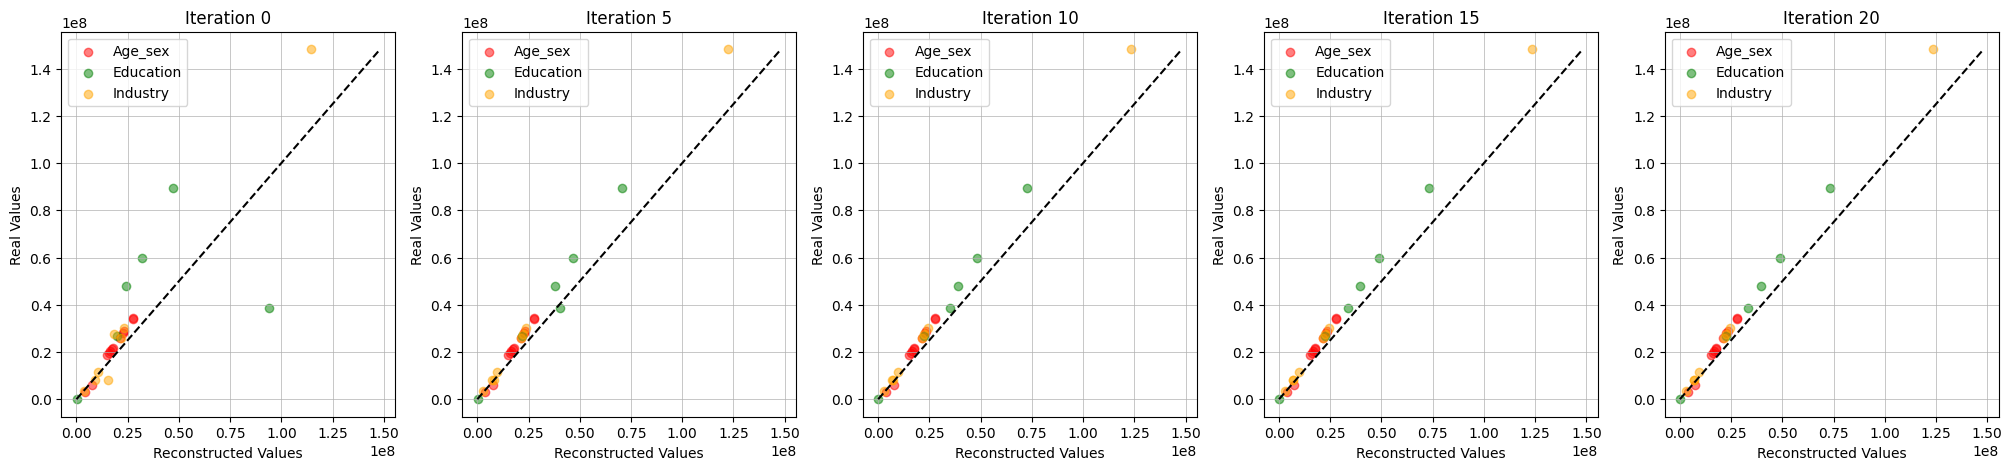

In [ ]:
fig, ax = plt.subplots(1,len(Age_points_recons),figsize=(25, 5))

for i in range(len(Age_points_recons)):
  ax[i].scatter(Age_points_recons[i], Age_points_real[i], c = 'red', label='Age_sex', alpha=0.5)
  ax[i].scatter(EDU_points_recons[i], EDU_points_real[i], c = 'green', label='Education', alpha = 0.5)
  ax[i].scatter(IND_points_recons[i], IND_points_real[i], c = 'orange', label='Industry', alpha = 0.5)
  ax[i].plot([0, max(ind_scatter_real.values)], [0, max(ind_scatter_real.values)], linestyle='--', color='black')
  ax[i].set_xlabel('Reconstructed Values')
  ax[i].set_ylabel('Real Values')
  ax[i].set_title('Scatter Plot of Reconstructed vs Real Values')
  ax[i].legend()
  ax[i].grid(True, linewidth=0.5)
  ax[i].set_title(f"Iteration {5*i}")

#plt.title('Evolution of Scatter Plot of Reconstructed vs Real Values', loc = 'center')
plt.show()

In [ ]:
print("Step 15 : End IPF and Store REsults")
result = []
for a, s, e, i, r in tqdm(product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)), total = n_a*n_s*n_e*n_i*n_r):
    val = x[a, s, e, i, r]
    if val > 0:
        result.append({
            "AGE": age_map_reverse[a],
            "SEX": sex_map_reverse[s],
            "EDU": edu_map_reverse[e],
            "IND": ind_map_reverse[i],
            "REGION": region_reverse[r],
            "VALUE": val
        })

df_result = pd.DataFrame(result)
df_result
df_result.to_csv('result2.csv', index=False)

Step 15 : End IPF and Store REsults


100%|██████████| 1449504/1449504 [00:01<00:00, 947858.39it/s]


,AGE,SEX,EDU,IND,REGION,VALUE
0,Y1529,Females,ISCED97_0_1,,AL011,131.222288
1,Y1529,Females,ISCED97_0_1,,AL012,368.172840
2,Y1529,Females,ISCED97_0_1,,AL013,80.821236
3,Y1529,Females,ISCED97_0_1,,AL014,152.791498
4,Y1529,Females,ISCED97_0_1,,AL015,267.255638
...,...,...,...,...,...,...
1151707,YLT15,Males,ISCED97_X,R-U,TRC22,3419.249293
1151708,YLT15,Males,ISCED97_X,R-U,TRC31,1673.628005
1151709,YLT15,Males,ISCED97_X,R-U,TRC32,1206.471596
1151710,YLT15,Males,ISCED97_X,R-U,TRC33,1146.459930


In [ ]:
df_result['VALUE'].sum() # Check that we have sensible values for total European population

np.float64(468648434.0000019)

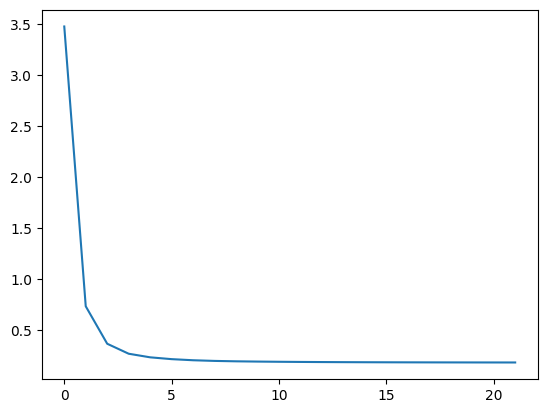

In [ ]:
plt.plot(Delta)
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.title('Evolution of Delta')
plt.show()

In [ ]:
reconstructed_nuts2_cross = defaultdict(float)
for a, s, e, i, r in product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)):
    n2 = region_to_nuts2.get(r, None)
    if n2 is not None:
        reconstructed_nuts2_cross[(a, s, e, i, n2)] += x_cross[a, s, e, i, r]

In [ ]:
reconstructed_nuts2_cross_seed = defaultdict(float)
for a, s, e, i, r in product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)):
    n2 = region_to_nuts2.get(r, None)
    if n2 is not None:
        reconstructed_nuts2_cross_seed[(a, s, e, i, n2)] += x_cross_seed[a, s, e, i, r]

In [ ]:
common_keys = set(nuts2_joint.index).intersection(set(reconstructed_nuts2.keys()))


nuts2_joint_aligned = nuts2_joint.reindex(common_keys)
reconstructed_aligned = pd.Series(reconstructed_nuts2).reindex(common_keys)
cross_recons_aligned = pd.Series(reconstructed_nuts2_cross).reindex(common_keys)
cross_recons_aligned_seed = pd.Series(reconstructed_nuts2_cross_seed).reindex(common_keys)

p = np.array(reconstructed_aligned)
q = np.array(nuts2_joint_aligned)
t = np.array(cross_recons_aligned)
s = np.array(cross_recons_aligned_seed)

p/= p.sum()
q/= q.sum()
t/= t.sum()
s/= s.sum()


def l1(p,q): return np.abs(p-q).sum()
def l2(p,q): return np.sqrt(((p-q)**2).sum())
def l2(p,q): return np.sqrt(((p-q)**2).sum())
def kl(p,q,eps=1e-12):
    p = np.asarray(p)+eps; q = np.asarray(q)+eps
    p = p / p.sum(); q = q / q.sum()
    return float((rel_entr(p,q)).sum())   # KL(p||q)
def js_divergence(p,q,eps=1e-12):
    p = np.asarray(p)+eps; q = np.asarray(q)+eps
    p /= p.sum(); q /= q.sum()
    m = 0.5*(p+q)
    return 0.5*rel_entr(p,m).sum() + 0.5*rel_entr(q,m).sum()



print(f"\nL1 distance true, cross: {l1(q,t):.6f} and true, x : {l1(q,p):.6f}, and true,noipf : {l1(q,s):.6f}")
print(f"L2 distance true, cross: {l2(q,t):.6f} and true, x : {l2(q,p):.6f}, and true,noipf : {l2(q,s):.6f}")
print(f"KL distance true, cross: {kl(q,t):.6f} and true, x : {kl(q,p):.6f}, and true,noipf : {kl(q,s):.6f}")
print(f"JS distance true, cross: {js_divergence(q,t):.6f} and true, x : {js_divergence(q,p):.6f}, and true,noipf : {js_divergence(q,s):.6f}")


L1 distance true, cross: 0.968210 and true, x : 0.044553, and true,noipf : 1.512631
L2 distance true, cross: 0.012498 and true, x : 0.000714, and true,noipf : 0.013366
KL distance true, cross: 7.841071 and true, x : 0.013198, and true,noipf : 8.639998
JS distance true, cross: 0.220495 and true, x : 0.004376, and true,noipf : 0.449781


In [ ]:
recons_nuts2_seed = defaultdict(float)
for a, s, e, i, r in tqdm(product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)), total = n_a*n_s*n_e*n_i):
    n2 = region_to_nuts2.get(r)
    if n2:
        recons_nuts2_seed[(a, s, e, i, n2)] += seed[a, s, e, i, r]

reconstructed_aligned_seed = pd.Series(recons_nuts2_seed,dtype = 'float64').reindex(common_keys)

1449504it [00:01, 1090535.35it/s]


In [ ]:
# Convert to numpy arrays for calculations
y_true = nuts2_joint_aligned.values
y_pred = reconstructed_aligned.values
y_pred_cross = cross_recons_aligned.values
y_no_ipf = cross_recons_aligned_seed.values

# R2 Score
r2 = r2_score(y_true, y_pred)
r2_cross = r2_score(y_true, y_pred_cross)
r2_no_ipf = r2_score(y_true, y_no_ipf)
print(f"R2 Score: {r2:.4f}, R2 Score Cross: {r2_cross:.4f}, R2 Score No IPF: {r2_no_ipf:.4f}")

# Total Absolute Error (TAE)
tae = np.sum(np.abs(y_true - y_pred)) / y_true.sum() *100
tae_cross = np.sum(np.abs(y_true - y_pred_cross)) / y_true.sum()
tae_no_ipf = np.sum(np.abs(y_true - y_no_ipf)) / y_true.sum()
print(f"Total Absolute Error (TAE): {tae:.2f}, TAE Cross: {tae_cross:.2f}, TAE No IPF: {tae_no_ipf:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_cross = np.sqrt(mean_squared_error(y_true, y_pred_cross))
rmse_no_ipf = np.sqrt(mean_squared_error(y_true, y_no_ipf))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}, RMSE Cross: {rmse_cross:.4f}, RMSE No IPF: {rmse_no_ipf:.4f}")

# Z-score
std_dev = np.std(y_true - y_pred)
if std_dev > 0:
    z_scores = (y_true - y_pred) / std_dev
    mean_abs_z_score = np.mean(np.abs(z_scores))
    print(f"Mean Absolute Z-score: {mean_abs_z_score:.4f}")
else:
    print("Standard deviation is zero, cannot calculate Z-scores.")

std_dev_cross = np.std(y_true - y_pred_cross)
if std_dev_cross > 0:
    z_scores_cross = (y_true - y_pred_cross) / std_dev_cross
    mean_abs_z_score_cross = np.mean(np.abs(z_scores_cross))
    print(f"Mean Absolute Z-score Cross: {mean_abs_z_score_cross:.4f}")
else:
    print("Standard deviation is zero, cannot calculate Z-scores.")

std_dev_no_ipf = np.std(y_true - y_no_ipf)
if std_dev_no_ipf > 0:
    z_scores_no_ipf = (y_true - y_no_ipf) / std_dev_no_ipf
    mean_abs_z_score_no_ipf = np.mean(np.abs(z_scores_no_ipf))
    print(f"Mean Absolute Z-score No IPF: {mean_abs_z_score_no_ipf:.4f}")
else:
    print("Standard deviation is zero, cannot calculate Z-scores.")


# 6. E > 5% (Percentage of cells with relative error greater than 5%)
# Avoid division by zero for relative error
relative_errors = np.abs(y_true - y_pred) / (y_true + 1e-9) # Add a small epsilon to avoid division by zero
e_gt_5_percent = np.mean(relative_errors > 0.05) * 100

relative_errors_cross = np.abs(y_true - y_pred_cross) / (y_true + 1e-9) # Add a small epsilon to avoid division by zero
e_gt_5_percent_cross = np.mean(relative_errors_cross > 0.05) * 100

relative_errors_no_ipf = np.abs(y_true - y_no_ipf) / (y_true + 1e-9) # Add a small epsilon to avoid division by zero
e_gt_5_percent_no_ipf = np.mean(relative_errors_no_ipf > 0.05) * 100


print(f"Percentage of cells with relative error > 5% (E>5%): {e_gt_5_percent:.2f}%")
print(f"Percentage of cells with relative error cross > 5% (E>5%): {e_gt_5_percent_cross:.2f}%")
print(f"Percentage of cells with relative error noipf> 5% (E>5%): {e_gt_5_percent_no_ipf:.2f}%")

R2 Score: 0.9618, R2 Score Cross: 0.4373, R2 Score No IPF: -3.9835
Total Absolute Error (TAE): 19.64, TAE Cross: 0.66, TAE No IPF: 3.27
Root Mean Squared Error (RMSE): 2973.5562, RMSE Cross: 11406.8175, RMSE No IPF: 33947.4853
Mean Absolute Z-score: 0.2121
Mean Absolute Z-score Cross: 0.1853
Mean Absolute Z-score No IPF: 0.3104
Percentage of cells with relative error > 5% (E>5%): 96.25%
Percentage of cells with relative error cross > 5% (E>5%): 64.69%
Percentage of cells with relative error noipf> 5% (E>5%): 68.06%


## Synthetic IPF

In [ ]:
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict

# ---------------------------
# Step 1 : Define synthetic structure
# ---------------------------
n_nuts2 = 100
nuts2_list = [f"N2_{i:03d}" for i in range(n_nuts2)]
nuts3_list = [f"N3_{i:04d}" for i in range(n_nuts2*10)]

# Mapping NUTS3 → NUTS2
region_to_nuts2 = {}
for i, n2 in enumerate(nuts2_list):
    for j in range(10):
        r = nuts3_list[i*10 + j]
        region_to_nuts2[r] = n2

ages = [f"A{i}" for i in range(5)]
sexes = ["Males", "Females"]
edu = [f"Edu{i}" for i in range(4)]
ind = [f"Ind{i}" for i in range(6)]

n_a, n_s, n_e, n_i, n_r = len(ages), len(sexes), len(edu), len(ind), len(nuts3_list)

#Generate true joint distribution (ground truth)

np.random.seed(42)
true_population = np.zeros((n_a, n_s, n_e, n_i, n_r), dtype=int)
for r in range(n_r):
    power_of_ten = np.random.randint(3, 6)
    true_population[..., r] = np.random.dirichlet(np.ones(n_a*n_s*n_e*n_i), size=1).reshape(n_a, n_s, n_e, n_i) *(10**power_of_ten)

true_population_noisy = true_population.astype(float)

for a in range(n_a):
    for s in range(n_s):
        age_sex_factor = np.random.uniform(0.7, 1.3)
        true_population_noisy[a, s, :, :, :] *= age_sex_factor

for e in range(n_e):
    edu_factor = np.random.uniform(0.7, 1.3)
    true_population_noisy[:, :, e, :, :] *= edu_factor

for i in range(n_i):
    ind_factor = np.random.uniform(0.7, 1.3)
    true_population_noisy[:, :, :, i, :] *= ind_factor


true_population_noisy += np.random.normal(scale=0.01*true_population_noisy.mean(), size=true_population_noisy.shape)
true_population_noisy[true_population_noisy < 0] = 0
true_population = true_population_noisy.astype(int)


#Build mappings
age_map = {v:i for i,v in enumerate(ages)}
sex_map = {v:i for i,v in enumerate(sexes)}
edu_map = {v:i for i,v in enumerate(edu)}
ind_map = {v:i for i,v in enumerate(ind)}
region_map = {v:i for i,v in enumerate(nuts3_list)}
nuts2_map = {v:i for i,v in enumerate(nuts2_list)}


#Derive marginals
p_asr = pd.Series({ (a,s,r): true_population[a,s,:,:, r].sum()
                    for a,s,r in product(range(n_a), range(n_s), range(n_r)) })


#Nuts2 joint (Age×Sex×Edu×Ind)
nuts2_joint = defaultdict(int)
for a,s,e,i,r in product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)):
    n2 = nuts2_map[region_to_nuts2[nuts3_list[r]]]
    nuts2_joint[(a,s,e,i,n2)] += true_population[a,s,e,i,r].sum()
nuts2_joint = pd.Series(nuts2_joint)

nuts2_joint.index = pd.MultiIndex.from_tuples(
    nuts2_joint.index, names=["AGE_code", "SEX_code", "EDU_code", "IND_code", "NUTS2_code"]
)

true_population_series = pd.Series({(a,s,e,i,r) : true_population[a,s,e,i,r]
                                      for a,s,e,i,r in
                                      product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r))})
true_population_series.index = pd.MultiIndex.from_tuples(
    true_population_series.index, names=["AGE_code3", "SEX_code3", "EDU_code3", "IND_code3", "NUTS3_code3"]
)


print("Synthetic data generated")
print("True cube shape:", true_population.shape)
print("Number of NUTS2:", n_nuts2)
print("Number of NUTS3:", n_r)


Synthetic data generated
True cube shape: (5, 2, 4, 6, 1000)
Number of NUTS2: 100
Number of NUTS3: 1000


In [ ]:
x = np.zeros_like(true_population, dtype=float)
non_zero_mask = np.random.rand(*x.shape) < 0.8
x[non_zero_mask] = np.random.lognormal(mean=8, sigma=5, size=non_zero_mask.sum())

for axis, scale in zip([0,1,2,3], [1.5, 0.8, 2.0, 0.5]):
    x = np.moveaxis(x, axis, 0)
    x *= np.random.uniform(0.5*scale, 1.5*scale, size=x.shape[0])[:, None, None, None, None]
    x = np.moveaxis(x, 0, axis)

x =( x / x.sum() )* (true_population.sum())
x[x<0] = 0
x = x.astype(float)

for r in range(n_r):
    power_of_ten = np.random.randint(1,5)
    x[..., r] = x[..., r] *(10**power_of_ten)


x_series = pd.Series({(a,s,e,i,r) : x[a,s,e,i,r]
                                      for a,s,e,i,r in
                                      product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r))}).reindex(true_population_series.index).fillna(0)

print("Synthetic data (harder) generated")
print("Shape:", x.shape)
print("Total population:", x.sum())
print("Total true population:", true_population.sum())
print(f"Percentage of zero in x {(x==0).sum()*100/ (x.size):.3f}")

Synthetic data (harder) generated
Shape: (5, 2, 4, 6, 1000)
Total population: 41104968506.07653
Total true population: 34982604
Percentage of zero in x 19.988


In [ ]:
# Initialisation
x = np.zeros_like(true_population, dtype=float)

# Masque de cellules non nulles (sparse)
non_zero_mask = np.random.rand(*x.shape) < 0.8

# Génération lognormale, centrée sur l'ordre de grandeur de true_population
mean_true = np.mean(true_population)
std_true  = np.std(true_population)

# On utilise lognormal centré autour de la moyenne et écart relatif de true_population
x[non_zero_mask] = np.random.lognormal(mean=np.log(mean_true + 1),
                                       sigma=np.log(1 + std_true/(mean_true+1)),
                                       size=non_zero_mask.sum())

# Scaling par dimension pour introduire variation comme dans le code original
for axis, scale in zip([0,1,2,3], [1.5, 0.8, 2.0, 0.5]):
    x = np.moveaxis(x, axis, 0)
    factors = np.random.uniform(0.5*scale, 1.5*scale, size=x.shape[0])[:, None, None, None, None]
    x *= factors
    x = np.moveaxis(x, 0, axis)

# Scaling par NUTS3 (puissances de 10)
for r in range(n_r):
    power_of_ten = np.random.randint(3, 6)  # même ordre que true_population
    x[..., r] *= 10**power_of_ten

# Ajouter un peu de bruit
x += np.random.normal(scale=0.01*true_population.mean(), size=x.shape)
x[x < 0] = 0  # clip négatifs
x = x / x.sum() * true_population.sum()

x_series = pd.Series({(a,s,e,i,r) : x[a,s,e,i,r]
                                      for a,s,e,i,r in
                                      product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r))}).reindex(true_population_series.index).fillna(0)

print("Synthetic x generated with comparable magnitudes")
print("Mean x:", x.mean(), "Mean true:", true_population.mean())
print("Sum x:", x.sum(), "Sum true:", true_population.sum())


Synthetic x generated with comparable magnitudes
Mean x: 145.76085 Mean true: 145.76085
Sum x: 34982604.0 Sum true: 34982604


In [ ]:
true_population_series, x_series

(AGE_code3  SEX_code3  EDU_code3  IND_code3  NUTS3_code3
 0          0          0          0          0              595
                                             1              114
                                             2               12
                                             3               30
                                             4                0
                                                           ... 
 4          1          3          5          995              5
                                             996             25
                                             997              6
                                             998             20
                                             999              4
 Length: 240000, dtype: int64,
 AGE_code3  SEX_code3  EDU_code3  IND_code3  NUTS3_code3
 0          0          0          0          0                33.108503
                                             1                38.230220
       

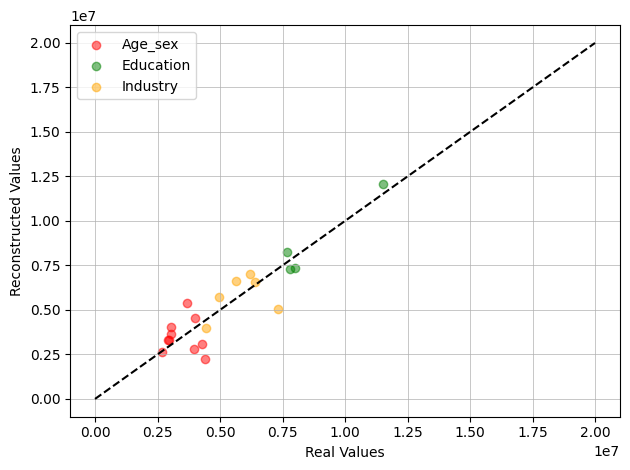

In [ ]:
nuts2_map_reverse = {v: k for k, v in nuts2_map.items()}
age_map_reverse = {v: k for k, v in age_map.items()}
sex_map_reverse = {v: i for i, v in sex_map.items()}
edu_map_reverse = {v: i for i, v in edu_map.items()}
ind_map_reverse = {v: i for i, v in ind_map.items()}
region_reverse = {v: i for i, v in region_map.items()}

max_iter = 500
tol = 1e-8
Delta = []
Age_points_recons = []
Age_points_real = []
EDU_points_recons  = []
EDU_points_real = []
IND_points_recons  = []
IND_points_real = []

Age_points_nuts3 = []
EDU_points_nuts3  = []
IND_points_nuts3  = []
Age_points_nuts3real = []
EDU_points_nuts3real  = []
IND_points_nuts3real  = []


age_sex_scatter_nuts3real = true_population_series.groupby(["AGE_code3", "SEX_code3"]).sum()
edu_scatter_nuts3real = true_population_series.groupby("EDU_code3").sum()
ind_scatter_nuts3real = true_population_series.groupby("IND_code3").sum()

age_sex_scatter_nuts3 = x_series.groupby(["AGE_code3", "SEX_code3"]).sum()
edu_scatter_nuts3 = x_series.groupby("EDU_code3").sum()
ind_scatter_nuts3 = x_series.groupby("IND_code3").sum()

Age_points_nuts3.append(age_sex_scatter_nuts3.values.copy())
Age_points_nuts3real.append(age_sex_scatter_nuts3real.values.copy())
EDU_points_nuts3.append(edu_scatter_nuts3.values.copy())
EDU_points_nuts3real.append(edu_scatter_nuts3real.values.copy())
IND_points_nuts3.append(ind_scatter_nuts3.values.copy())
IND_points_nuts3real.append(ind_scatter_nuts3real.values.copy())


plt.scatter(age_sex_scatter_nuts3real.values, age_sex_scatter_nuts3.values, c='red', label='Age_sex', alpha=0.5)
plt.scatter(edu_scatter_nuts3real.values, edu_scatter_nuts3.values, c='green', label='Education', alpha=0.5)
plt.scatter(ind_scatter_nuts3real.values, ind_scatter_nuts3.values, c='orange', label='Industry', alpha=0.5)
plt.plot([0, 2e7], [0, 2e7],linestyle='--', color='black')
plt.ylabel('Reconstructed Values')
plt.xlabel('Real Values')
#plt.title(f"Iteration {5*i}")
plt.legend()
plt.grid(True, linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
nuts2_map_reverse = {v: k for k, v in nuts2_map.items()}
age_map_reverse = {v: k for k, v in age_map.items()}
sex_map_reverse = {v: k for k, v in sex_map.items()}
edu_map_reverse = {v: k for k, v in edu_map.items()}
ind_map_reverse = {v: k for k, v in ind_map.items()}
region_map_reverse = {v: k for k, v in region_map.items()}


max_iter = 1000
tol = 1e-4
Delta = []
Age_points_recons = []
Age_points_real = []
EDU_points_recons  = []
EDU_points_real = []
IND_points_recons  = []
IND_points_real = []

Age_points_nuts3 = []
EDU_points_nuts3  = []
IND_points_nuts3  = []
Age_points_nuts3real = []
EDU_points_nuts3real  = []
IND_points_nuts3real  = []


age_sex_scatter_nuts3real = true_population_series.groupby(["AGE_code3", "SEX_code3"]).sum()
edu_scatter_nuts3real = true_population_series.groupby("EDU_code3").sum()
ind_scatter_nuts3real = true_population_series.groupby("IND_code3").sum()

x_series = pd.Series({(a,s,e,i,r) : x[a,s,e,i,r]
                                      for a,s,e,i,r in
                                      product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r))}).reindex(true_population_series.index).fillna(0)
age_sex_scatter_nuts3 = x_series.groupby(["AGE_code3", "SEX_code3"]).sum()
edu_scatter_nuts3 = x_series.groupby("EDU_code3").sum()
ind_scatter_nuts3 = x_series.groupby("IND_code3").sum()

Age_points_nuts3.append(age_sex_scatter_nuts3.values.copy())
Age_points_nuts3real.append(age_sex_scatter_nuts3real.values.copy())
EDU_points_nuts3.append(edu_scatter_nuts3.values.copy())
EDU_points_nuts3real.append(edu_scatter_nuts3real.values.copy())
IND_points_nuts3.append(ind_scatter_nuts3.values.copy())
IND_points_nuts3real.append(ind_scatter_nuts3real.values.copy())

reconstructed_nuts2 = defaultdict(float)
for a, s, e, i, r in product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)):
    n2 = nuts2_map[region_to_nuts2[nuts3_list[r]]]
    reconstructed_nuts2[(a, s, e, i, n2)] += x[a, s, e, i, r]

reconstructed_aligned = pd.Series(reconstructed_nuts2).reindex(nuts2_joint.index).fillna(0)

age_sex_scatter_real = nuts2_joint.groupby(["AGE_code", "SEX_code"]).sum()
edu_scatter_real = nuts2_joint.groupby("EDU_code").sum()
ind_scatter_real = nuts2_joint.groupby("IND_code").sum()

age_sex_scatter_recons = reconstructed_aligned.groupby(["AGE_code", "SEX_code"]).sum()
age_sex_scatter_real = nuts2_joint.groupby(["AGE_code", "SEX_code"]).sum()
Age_points_recons.append(age_sex_scatter_recons.values.copy())
Age_points_real.append(age_sex_scatter_real.values.copy())

edu_scatter_recons = reconstructed_aligned.groupby("EDU_code").sum()
edu_scatter_real = nuts2_joint.groupby("EDU_code").sum()
EDU_points_recons.append(edu_scatter_recons.values.copy())
EDU_points_real.append(edu_scatter_real.values.copy())

ind_scatter_recons = reconstructed_aligned.groupby("IND_code").sum()
IND_points_recons.append(ind_scatter_recons.values.copy())
IND_points_real.append(ind_scatter_real.values.copy())

for it in tqdm(range(max_iter)):
    x_old = x.copy()
    # C1 : NUTS2 Constraints (A,S,E,I)
    for a, s, e, i, n2 in product(range(n_a), range(n_s), range(n_e), range(n_i), range(len(nuts2_map))):
        n2_str = nuts2_map_reverse[n2]  # string NUTS2
        regions_in_n2 = [r for r, n2r in enumerate(nuts3_list) if region_to_nuts2[n2r] == n2_str]
        total = x[a, s, e, i, regions_in_n2].sum()
        target = nuts2_joint.get((a, s, e, i, n2), 0)
        if total > 0 and target > 0:
            x[a, s, e, i, regions_in_n2] *=  target / total

    # C2 : NUTS3 Contsraints (A,S)
    for a, s, r in product(range(n_a), range(n_s), range(n_r)):
        total = x[a, s, :, :, r].sum()
        target = p_asr.get((a, s, r), 0)
        if total > 0 and target > 0:
            x[a, s, :, :, r] *= target / total

    # Convergence diagnosis
    #delta = np.abs(x - x_old).sum()/x.sum()
    #print(delta)
    #if delta < 1e-12:
    #    print(f"Convergence atteinte avec delta")
    #    break

    # Add relative error Constraint
    reconstructed_nuts2 = defaultdict(float)
    for a, s, e, i, r in product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r)):
        n2 = nuts2_map[region_to_nuts2[nuts3_list[r]]]
        reconstructed_nuts2[(a, s, e, i, n2)] += x[a, s, e, i, r]

    rel_errors_n2 = []
    for key in nuts2_joint.index:
        ref = nuts2_joint.get(key, 0)
        est = reconstructed_nuts2.get(key, 0)
        if ref > 0:
            rel = abs(est - ref) / ref
            rel_errors_n2.append(rel)
    max_rel_error_n2 = max(rel_errors_n2)
    mean_rel_error_n2 = np.mean(rel_errors_n2)

    rel_err_as = []
    for key in p_asr.index:
        a,s,r = key
        ref = p_asr.get(key, 0)
        est = x[a,s,:,:,r].sum()
        if ref > 0:
            rel = abs(est - ref) / ref
            rel_err_as.append(rel)
    max_rel_error_as = max(rel_err_as)
    mean_rel_error_as = np.mean(rel_err_as)


    if max_rel_error_n2 < tol and max_rel_error_as < tol:
        print(f"Convergence atteinte avec erreur relative max AS = {max_rel_error_as:.2e} et erreur N2 = {max_rel_error_n2:.2e}")
        break
    if it%10 == 0 and it!= 0  :
      print(f"Iteration {it}: Mean Relative Error AS = {mean_rel_error_as}, Mean Relative Error N2 = {mean_rel_error_n2}")
    if it<=5 and it!= 0:
      reconstructed_aligned = pd.Series(reconstructed_nuts2).reindex(nuts2_joint.index).fillna(0)


      age_sex_scatter_recons = reconstructed_aligned.groupby(["AGE_code", "SEX_code"]).sum()
      Age_points_recons.append(age_sex_scatter_recons.values.copy())
      Age_points_real.append(age_sex_scatter_real.values.copy())

      edu_scatter_recons = reconstructed_aligned.groupby("EDU_code").sum()
      EDU_points_recons.append(edu_scatter_recons.values.copy())
      EDU_points_real.append(edu_scatter_real.values.copy())

      ind_scatter_recons = reconstructed_aligned.groupby("IND_code").sum()
      IND_points_recons.append(ind_scatter_recons.values.copy())
      IND_points_real.append(ind_scatter_real.values.copy())


      x_series = pd.Series({(a,s,e,i,r) : x[a,s,e,i,r]
                                      for a,s,e,i,r in
                                      product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r))}).reindex(true_population_series.index).fillna(0)
      age_sex_scatter_nuts3 = x_series.groupby(["AGE_code3", "SEX_code3"]).sum()
      edu_scatter_nuts3 = x_series.groupby("EDU_code3").sum()
      ind_scatter_nuts3 = x_series.groupby("IND_code3").sum()

      Age_points_nuts3.append(age_sex_scatter_nuts3.values.copy())
      Age_points_nuts3real.append(age_sex_scatter_nuts3real.values.copy())
      EDU_points_nuts3.append(edu_scatter_nuts3.values.copy())
      EDU_points_nuts3real.append(edu_scatter_nuts3real.values.copy())
      IND_points_nuts3.append(ind_scatter_nuts3.values.copy())
      IND_points_nuts3real.append(ind_scatter_nuts3real.values.copy())

    Delta.append(max(mean_rel_error_as, mean_rel_error_n2))
    if mean_rel_error_as < tol and mean_rel_error_n2 < tol:
        print(f"Convergence atteinte à l'itération {it} avec erreur relative moyenne AS = {mean_rel_error_as:.2e} et erreur N2 = {mean_rel_error_n2}")
        break
    if len(Delta) > 5 and abs(Delta[-1] - Delta[-5]) < 1e-5:
     print(f"Stagnation détectée à l'itération {it}")
     break


  1%|          | 11/1000 [01:04<1:33:49,  5.69s/it]

Iteration 10: Mean Relative Error AS = 5.930241011924765e-17, Mean Relative Error N2 = 0.004260369349377621


  2%|▏         | 21/1000 [01:59<1:30:31,  5.55s/it]

Iteration 20: Mean Relative Error AS = 5.980147935356681e-17, Mean Relative Error N2 = 0.0025482461893929706


  3%|▎         | 31/1000 [02:51<1:22:52,  5.13s/it]

Iteration 30: Mean Relative Error AS = 5.647219734699526e-17, Mean Relative Error N2 = 0.0018499076458236476


  4%|▍         | 41/1000 [03:45<1:23:02,  5.20s/it]

Iteration 40: Mean Relative Error AS = 4.0509227505685753e-17, Mean Relative Error N2 = 0.0013332265913443973


  5%|▌         | 51/1000 [04:40<1:24:16,  5.33s/it]

Iteration 50: Mean Relative Error AS = 2.810668722706064e-17, Mean Relative Error N2 = 0.0010293871668124012


  6%|▌         | 61/1000 [05:33<1:24:55,  5.43s/it]

Iteration 60: Mean Relative Error AS = 2.1733051798653992e-17, Mean Relative Error N2 = 0.0008758816456325681


  7%|▋         | 71/1000 [06:26<1:25:16,  5.51s/it]

Iteration 70: Mean Relative Error AS = 1.770044451882302e-17, Mean Relative Error N2 = 0.0007826373802853984


  8%|▊         | 81/1000 [07:18<1:17:33,  5.06s/it]

Iteration 80: Mean Relative Error AS = 1.5953017744797718e-17, Mean Relative Error N2 = 0.0007253612958379046


  9%|▉         | 91/1000 [08:11<1:18:57,  5.21s/it]

Iteration 90: Mean Relative Error AS = 1.445287734796699e-17, Mean Relative Error N2 = 0.0006941083028477136


  9%|▉         | 91/1000 [08:17<1:22:47,  5.46s/it]

Stagnation détectée à l'itération 91


In [ ]:
reconstructed_aligned = pd.Series(reconstructed_nuts2).reindex(nuts2_joint.index).fillna(0)


age_sex_scatter_recons = reconstructed_aligned.groupby(["AGE_code", "SEX_code"]).sum()
age_sex_scatter_real = nuts2_joint.groupby(["AGE_code", "SEX_code"]).sum()
Age_points_recons.append(age_sex_scatter_recons.values)
Age_points_real.append(age_sex_scatter_real.values)

edu_scatter_recons = reconstructed_aligned.groupby("EDU_code").sum()
edu_scatter_real = nuts2_joint.groupby("EDU_code").sum()
EDU_points_recons.append(edu_scatter_recons.values)
EDU_points_real.append(edu_scatter_real.values)

ind_scatter_recons = reconstructed_aligned.groupby("IND_code").sum()
ind_scatter_real = nuts2_joint.groupby("IND_code").sum()
IND_points_recons.append(ind_scatter_recons.values)
IND_points_real.append(ind_scatter_real.values)

x_series = pd.Series({(a,s,e,i,r) : x[a,s,e,i,r]
                                      for a,s,e,i,r in
                                      product(range(n_a), range(n_s), range(n_e), range(n_i), range(n_r))}).reindex(true_population_series.index).fillna(0)
age_sex_scatter_nuts3 = x_series.groupby(["AGE_code3", "SEX_code3"]).sum()
edu_scatter_nuts3 = x_series.groupby("EDU_code3").sum()
ind_scatter_nuts3 = x_series.groupby("IND_code3").sum()

Age_points_nuts3.append(age_sex_scatter_nuts3.values)
Age_points_nuts3real.append(age_sex_scatter_nuts3real.values)
EDU_points_nuts3.append(edu_scatter_nuts3.values)
EDU_points_nuts3real.append(edu_scatter_nuts3real.values)
IND_points_nuts3.append(ind_scatter_nuts3.values)
IND_points_nuts3real.append(ind_scatter_nuts3real.values)

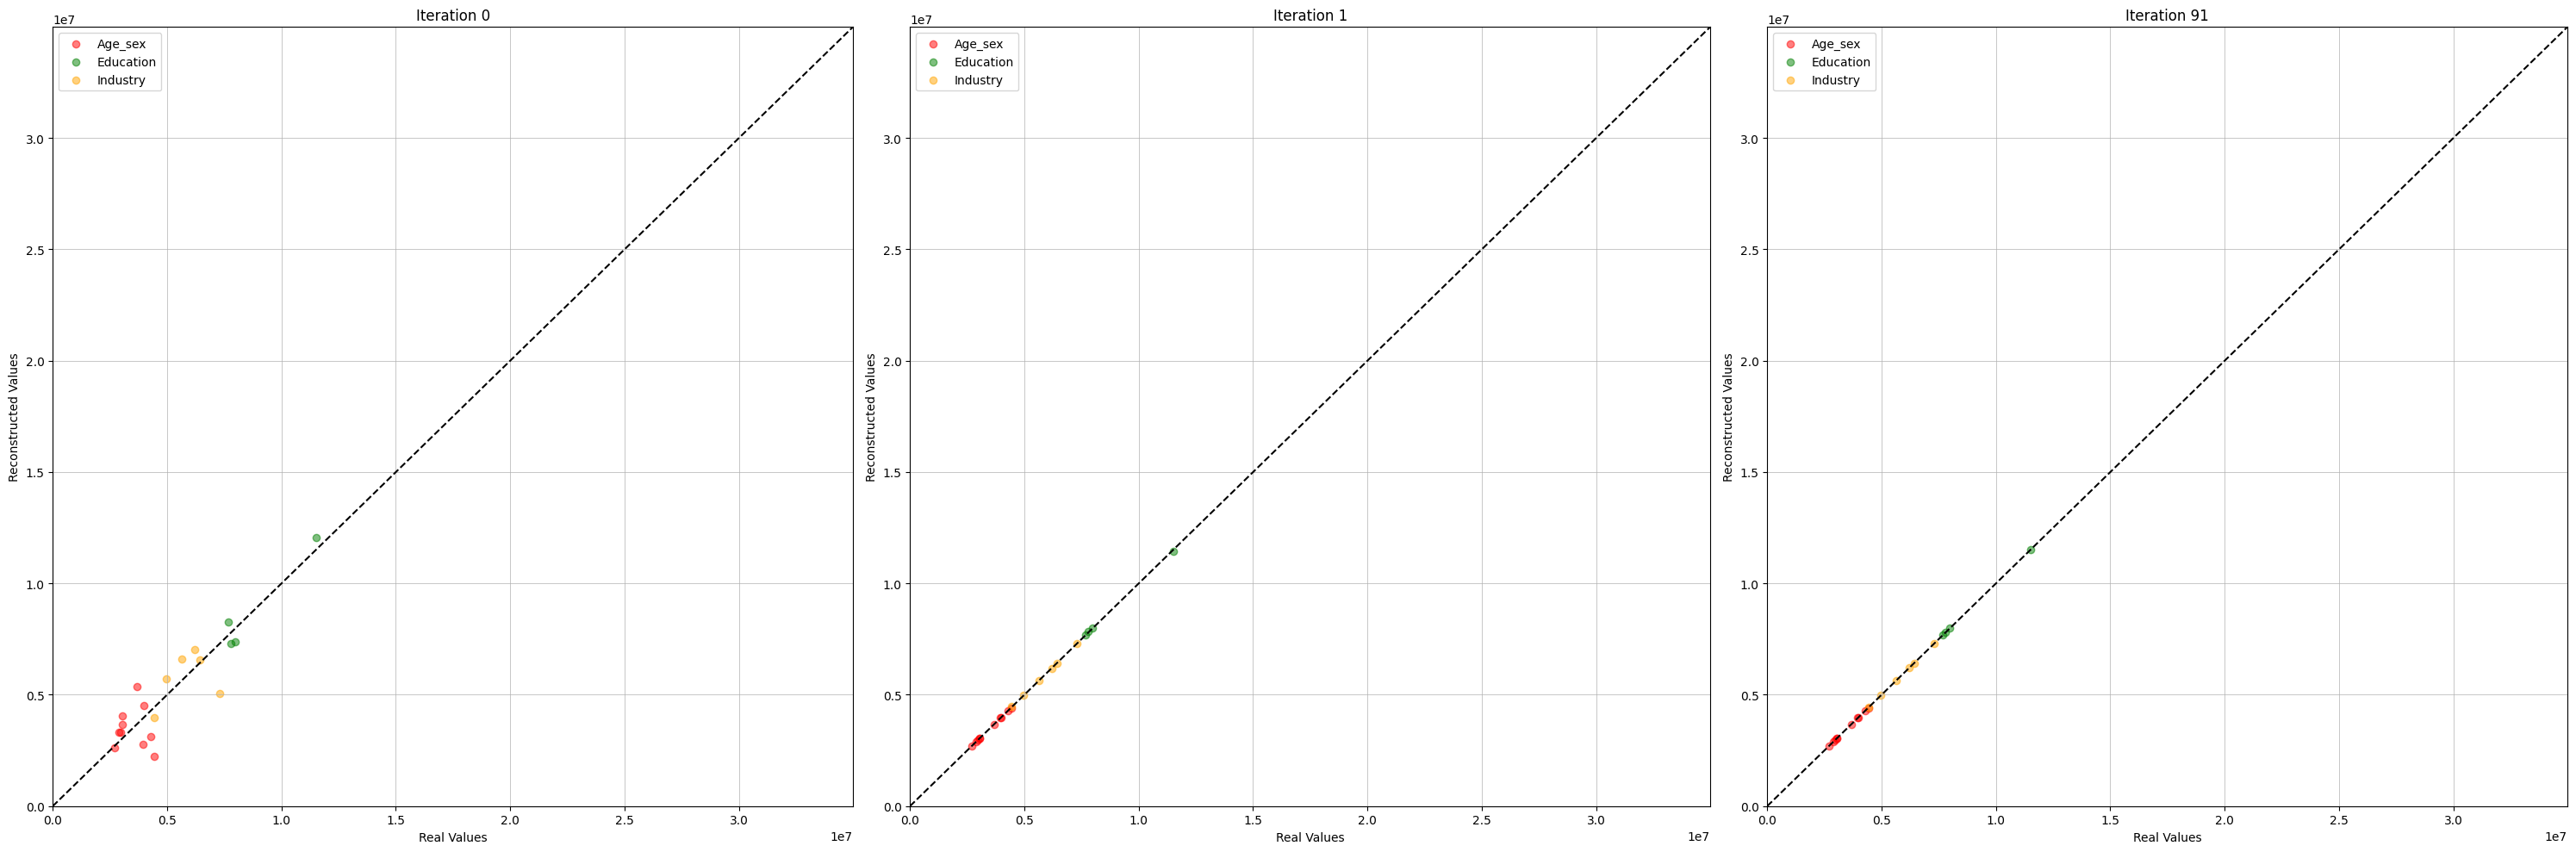

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax = ax.flatten()
# Plot: first (0), second (1), and last
plot_indices = [0, 1, len(Age_points_recons) - 1]
titles = ["Iteration 0", "Iteration 1", f"Iteration {it}"] # Titles for the plots

for i, idx in enumerate(plot_indices):
    ax[i].scatter(Age_points_real[idx], Age_points_recons[idx], c='red', label='Age_sex', alpha=0.5)
    ax[i].scatter(EDU_points_real[idx], EDU_points_recons[idx], c='green', label='Education', alpha=0.5)
    ax[i].scatter(IND_points_real[idx], IND_points_recons[idx], c='orange', label='Industry', alpha=0.5)
    ax[i].plot([0, true_population.sum()], [0, true_population.sum()], linestyle='--', color='black')
    ax[i].set_ylabel('Reconstructed Values')
    ax[i].set_xlabel('Real Values')
    ax[i].set_xlim([0, true_population.sum()])
    ax[i].set_ylim([0, true_population.sum()])
    ax[i].set_title(titles[i]) # Use the predefined titles
    ax[i].legend()
    ax[i].grid(True, linewidth=0.5)

plt.tight_layout()
plt.show()

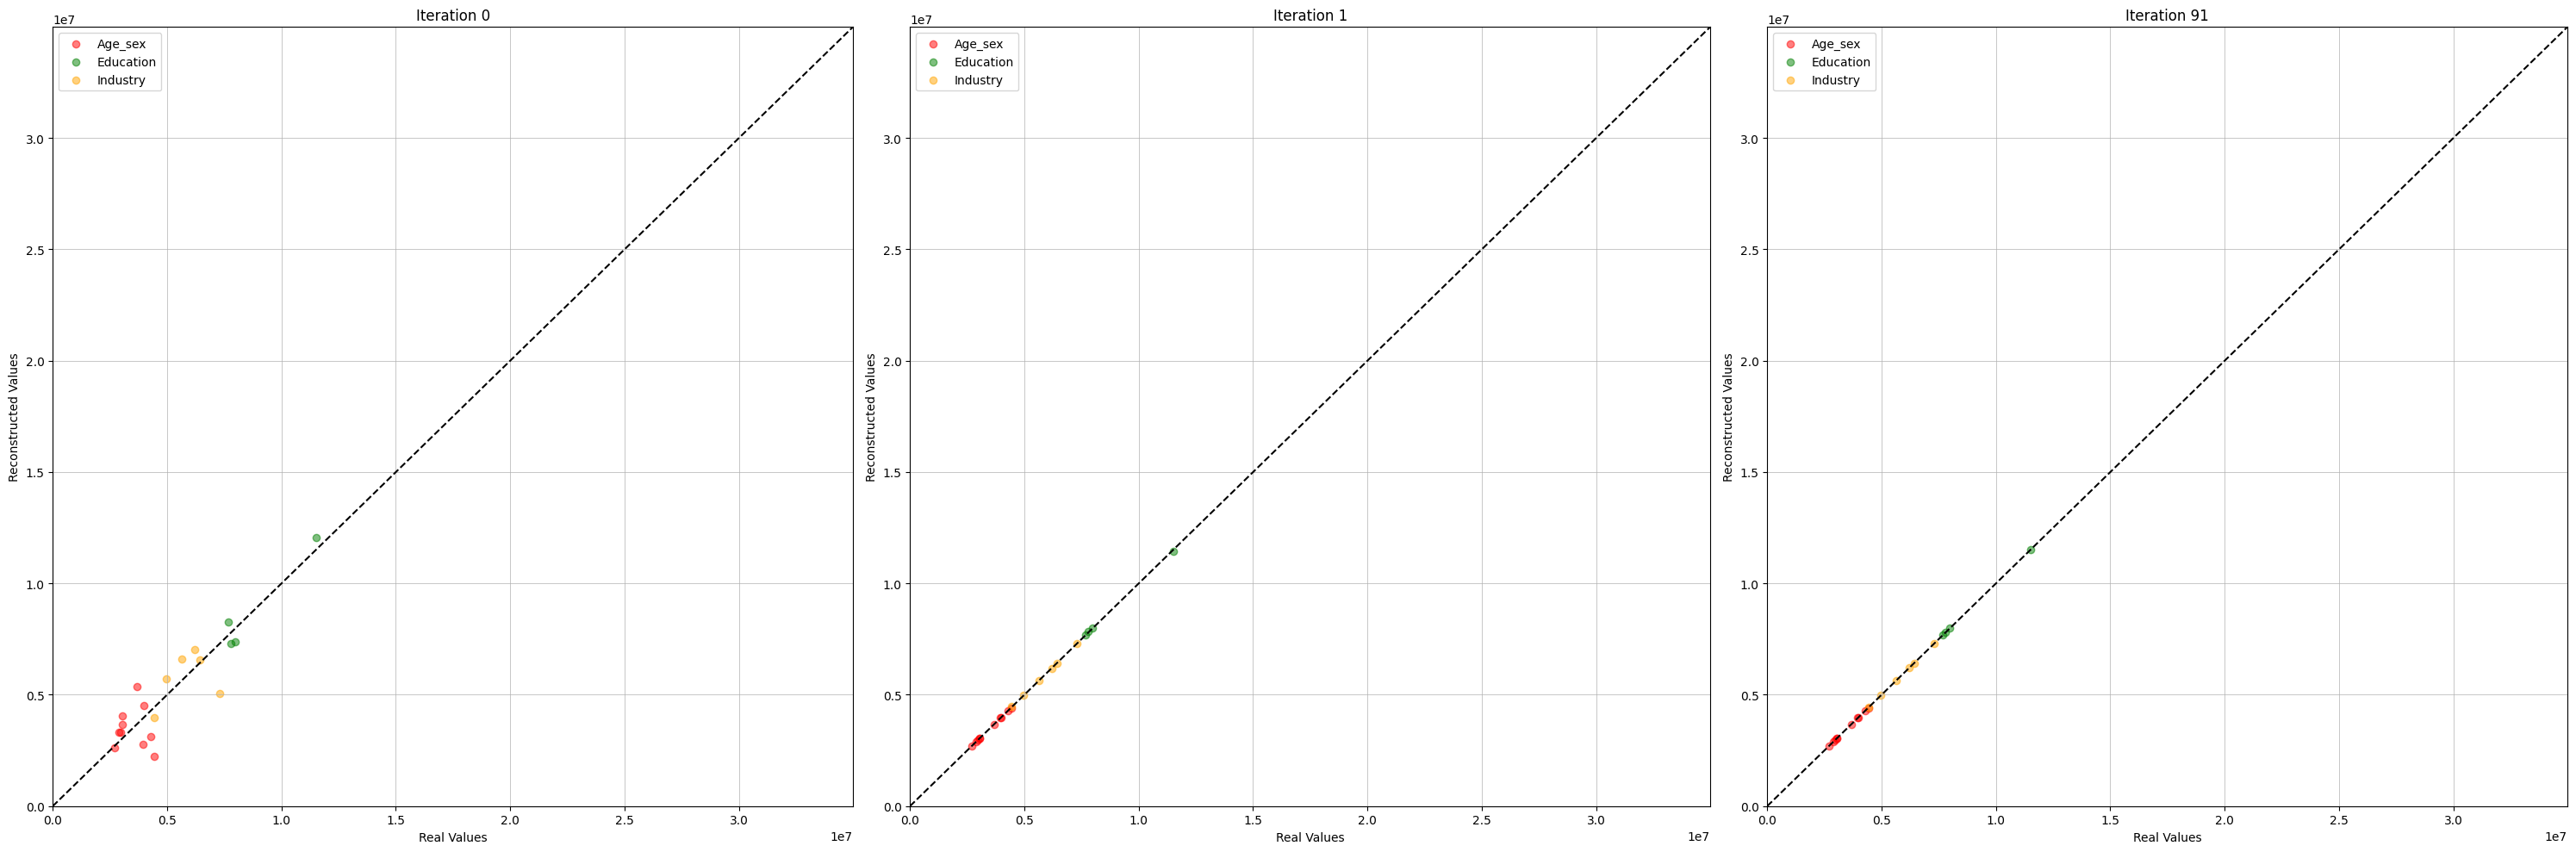

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax = ax.flatten()
# Plot: first (0), second (1), and last
plot_indices = [0, 1, len(Age_points_recons) - 1]
titles = ["Iteration 0", "Iteration 1", f"Iteration {it}"] # Titles for the plots

for i, idx in enumerate(plot_indices):
    ax[i].scatter(Age_points_nuts3real[idx], Age_points_nuts3[idx], c='red', label='Age_sex', alpha=0.5)
    ax[i].scatter(EDU_points_nuts3real[idx], EDU_points_nuts3[idx], c='green', label='Education', alpha=0.5)
    ax[i].scatter(IND_points_nuts3real[idx], IND_points_nuts3[idx], c='orange', label='Industry', alpha=0.5)
    ax[i].plot([0, true_population.sum()], [0, true_population.sum()], linestyle='--', color='black')
    ax[i].set_ylabel('Reconstructed Values')
    ax[i].set_xlabel('Real Values')
    ax[i].set_xlim([0, true_population.sum()])
    ax[i].set_ylim([0, true_population.sum()])
    ax[i].set_title(titles[i]) # Use the predefined titles
    ax[i].legend()
    ax[i].grid(True, linewidth=0.5)

plt.tight_layout()
plt.show()

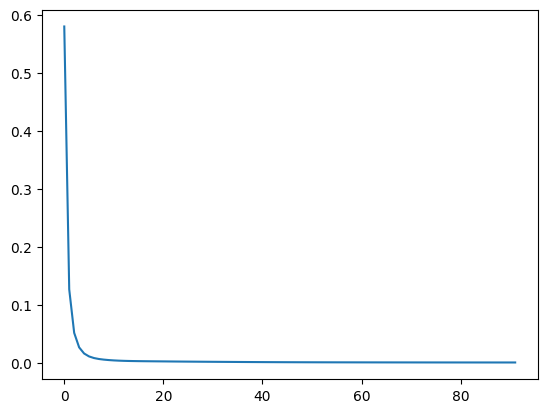

In [ ]:
plt.plot(Delta)

In [ ]:
true_population_aligned = true_population_series.reindex(true_population_series.index).fillna(0)
x_aligned = x_series.reindex(true_population_series.index).fillna(0)

p = np.array(x_aligned, dtype=float)
q = np.array(true_population_aligned, dtype=float)
p/= p.sum()
q/= q.sum()


def l1(p,q): return np.abs(p-q).sum()
def l2(p,q): return np.sqrt(((p-q)**2).sum())
def kl(p,q,eps=1e-12):
    p = np.asarray(p)+eps; q = np.asarray(q)+eps
    p = p / p.sum(); q = q / q.sum()
    return float((rel_entr(p,q)).sum())   # KL(p||q)
def js_divergence(p,q,eps=1e-12):
    p = np.asarray(p)+eps; q = np.asarray(q)+eps
    p /= p.sum(); q /= q.sum()
    m = 0.5*(p+q)
    return 0.5*rel_entr(p,m).sum() + 0.5*rel_entr(q,m).sum()



print(f"\nL1 distance true, x : {l1(q,p):.6f}")
print(f"L2 distance true, x : {l2(q,p):.6f}")
print(f"KL distance true, x : {kl(q,p):.6f}")
print(f"JS distance true, x : {js_divergence(q,p):.6f}")


L1 distance true, x : 0.965780
L2 distance true, x : 0.004514
KL distance true, x : 3.374867
JS distance true, x : 0.203994


In [ ]:
common_keys = set(nuts2_joint.index).intersection(set(reconstructed_nuts2.keys()))

nuts2_joint_aligned = nuts2_joint.reindex(common_keys)
reconstructed_aligned = pd.Series(reconstructed_nuts2).reindex(common_keys)

p = np.array(reconstructed_aligned, dtype=float)
q = np.array(nuts2_joint_aligned, dtype=float)

p/= p.sum()
q/= q.sum()

def l1(p,q): return np.abs(p-q).sum()
def l2(p,q): return np.sqrt(((p-q)**2).sum())
def l2(p,q): return np.sqrt(((p-q)**2).sum())
def kl(p,q,eps=1e-12):
    p = np.asarray(p)+eps; q = np.asarray(q)+eps
    p = p / p.sum(); q = q / q.sum()
    return float((rel_entr(p,q)).sum())   # KL(p||q)
def js_divergence(p,q,eps=1e-12):
    p = np.asarray(p)+eps; q = np.asarray(q)+eps
    p /= p.sum(); q /= q.sum()
    m = 0.5*(p+q)
    return 0.5*rel_entr(p,m).sum() + 0.5*rel_entr(q,m).sum()


# Update print statements to reflect the variables being compared
print(f"\nL1 distance true (NUTS2), reconstructed (NUTS2): {l1(q,p):.6f}")
print(f"L2 distance true (NUTS2), reconstructed (NUTS2): {l2(q,p):.6f}")
print(f"KL distance true (NUTS2), reconstructed (NUTS2): {kl(q,p):.6f}")
print(f"JS distance true (NUTS2), reconstructed (NUTS2): {js_divergence(q,p):.6f}")


L1 distance true (NUTS2), reconstructed (NUTS2): 0.000300
L2 distance true (NUTS2), reconstructed (NUTS2): 0.000048
KL distance true (NUTS2), reconstructed (NUTS2): 0.000041
JS distance true (NUTS2), reconstructed (NUTS2): 0.000010


In [ ]:
# Convert to numpy arrays for calculations
y_true = nuts2_joint_aligned.values
y_pred = reconstructed_aligned.values

# R2 Score
r2 = r2_score(y_true, y_pred)
print(f"R2 Score: {r2:.4f}")

# Total Absolute Error (TAE)
tae = np.sum(np.abs(y_true - y_pred)) / y_true.sum() *100
print(f"Total Absolute Error (TAE): {tae:.2f}%")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Z-score
std_dev = np.std(y_true - y_pred)
if std_dev > 0:
    z_scores = (y_true - y_pred) / std_dev
    mean_abs_z_score = np.mean(np.abs(z_scores))
    print(f"Mean Absolute Z-score: {mean_abs_z_score:.4f}")
else:
    print("Standard deviation is zero, cannot calculate Z-scores.")

# E > 5% (Percentage of cells with relative error greater than 5%)
relative_errors = np.abs(y_true - y_pred) / (y_true + 1e-9)
e_gt_5_percent = np.mean(relative_errors > 0.05) * 100
print(f"Percentage of cells with relative error > 5% (E>5%): {e_gt_5_percent:.2f}%")

R2 Score: 0.9999
Total Absolute Error (TAE): 0.03%
Root Mean Squared Error (RMSE): 10.7820
Mean Absolute Z-score: 0.0405
Percentage of cells with relative error > 5% (E>5%): 0.31%


In [ ]:
y_true = true_population_aligned.values
y_pred = x_aligned.values

# R2 Score
r2 = r2_score(y_true, y_pred)
print(f"R2 Score: {r2:.4f}")

# Total Absolute Error (TAE)
tae = np.sum(np.abs(y_true - y_pred)) / y_true.sum()
print(f"Total Absolute Error (TAE): {tae:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Z-score
std_dev = np.std(y_true - y_pred)
if std_dev > 0:
    z_scores = (y_true - y_pred) / std_dev
    mean_abs_z_score = np.mean(np.abs(z_scores))
    print(f"Mean Absolute Z-score: {mean_abs_z_score:.4f}")
else:
    print("Standard deviation is zero, cannot calculate Z-scores.")

# E > 5% (Percentage of cells with relative error greater than 5%)
relative_errors = np.abs(y_true - y_pred) / (y_true+1e-12)
e_gt_5_percent = np.mean(relative_errors > 0.01) * 100
print(f"Percentage of cells with relative error > 5% (E>5%): {e_gt_5_percent:.2f}%")

R2 Score: -0.0947
Total Absolute Error (TAE): 0.97
Root Mean Squared Error (RMSE): 322.3581
Mean Absolute Z-score: 0.4367
Percentage of cells with relative error > 5% (E>5%): 98.43%


## Différent transition hierarchical model


In [ ]:
def transition_model(V_2001, V_2021, sigma=1e-5):
    R, K = V_2001.shape

    s0 = numpyro.sample("s0", dist.Gamma(1.0, 1.0))
    s1 = numpyro.sample("s1", dist.Gamma(1.0, 1.0))

    T = []
    for i in range(K):
        gamma_i = s0 * jnp.ones(K) + s1 * jnp.eye(K)[i]
        That_i = numpyro.sample(f"That_{i}", dist.Dirichlet(gamma_i).expand([R]).to_event(1))  # (R, K)
        alpha_i = numpyro.sample(f"alpha_{i}", dist.Gamma(1.0, 1.0))
        T_i = numpyro.sample(f"T_{i}", dist.Dirichlet(alpha_i * That_i).to_event(1))  # (R, K)
        T.append(T_i)

    T = jnp.stack(T, axis=1)  # (R, K, K)

    for r in range(R):
        logits = jnp.dot(T[r], V_2001[r])  # (K,)
        numpyro.sample(f"obs_{r}", dist.Normal(logits, sigma).to_event(1), obs=V_2021[r])

kernel = NUTS(transition_model)
mcmc = MCMC(kernel, num_warmup=200, num_samples=500, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), V_2001=V_2001, V_2021=V_2021)
samples = mcmc.get_samples()


  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

array([[<Axes: title={'center': 'T_2'}>, <Axes: title={'center': 'T_2'}>],
       [<Axes: title={'center': 'That_2'}>,
        <Axes: title={'center': 'That_2'}>]], dtype=object)

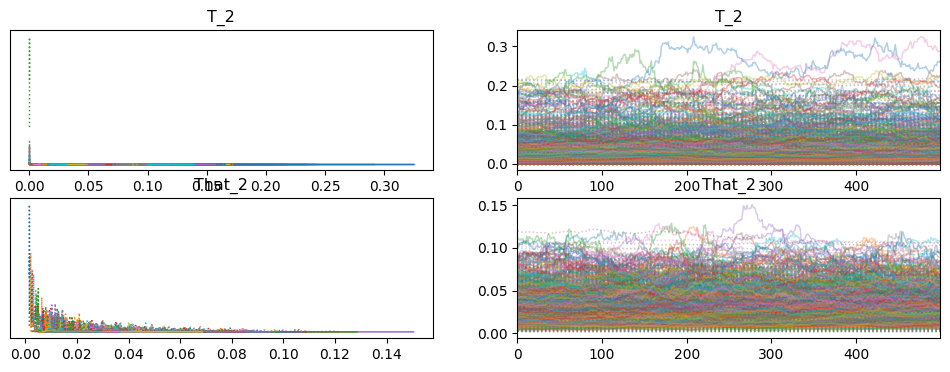

In [ ]:
idata = az.from_numpyro(mcmc)

az.plot_trace(idata, var_names=["T_2", "That_2"], compact=True)

In [ ]:
az.summary(idata, round_to=2)

KeyboardInterrupt: 

array([<Axes: title={'center': 's0\n0'}>,
       <Axes: title={'center': 's0\n1'}>], dtype=object)

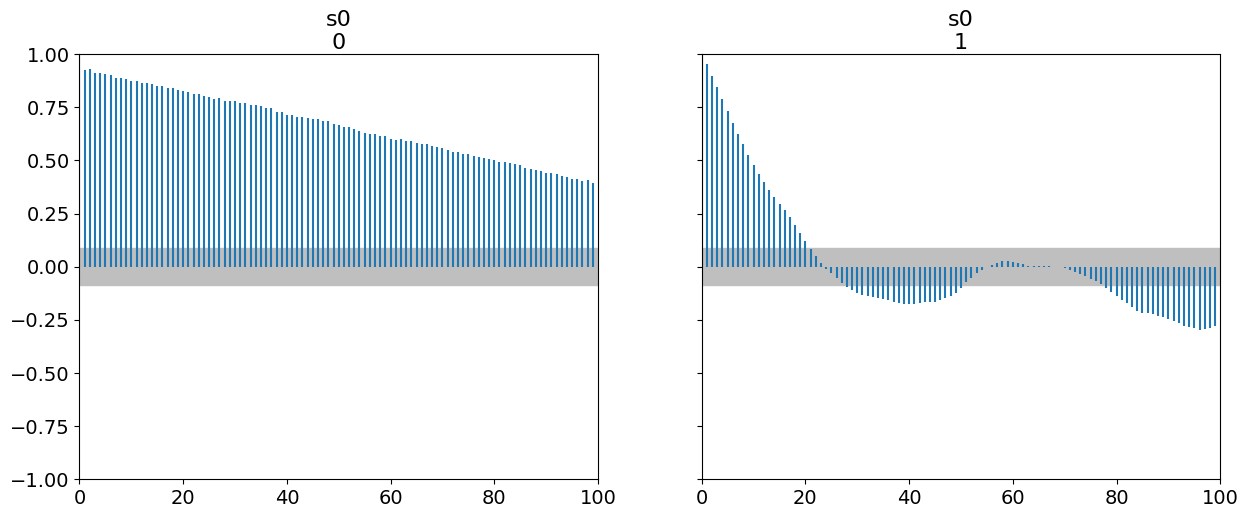

In [ ]:
az.plot_autocorr(idata, var_names=["s0"])

### Transition matrix with Bayesian

In [ ]:
df_2021_nuts2  = pd.read_csv('/content/drive/MyDrive/RESEARCH/ASEI_NUTS2_2021.csv', index_col = False)
df_2021_nuts2 = df_2021_nuts2.drop(columns = ['TIME','PROVIDER','FLAGS','FOOTNOTES'])
df_2021_nuts2 = df_2021_nuts2.drop(df_2021_nuts2[df_2021_nuts2['VALUE'] == ':'].index)
df_2021_nuts2 = df_2021_nuts2.dropna()
df_2021_nuts2 = df_2021_nuts2[df_2021_nuts2['GEO'].str.startswith('FR')]
df_2021_nuts2['VALUE'] = df_2021_nuts2['VALUE'].astype(int)

# Map and aggregate Data
edu2021_map = {
    'ISCED11_5': 'ISCED11_5_8',
    'ISCED11_6': 'ISCED11_5_8',
    'ISCED11_7': 'ISCED11_5_8',
    'ISCED11_8': 'ISCED11_5_8',
    'ISCED11_1': 'ISCED11_1',
    'ISCED11_2': 'ISCED11_2',
    'ISCED11_3': 'ISCED11_3',
    'ISCED11_4': 'ISCED11_4',
    'NAP': 'UNK',
    'NONE': 'UNK',
    'UNK': 'UNK'
}
df_2021_nuts2['EDU'] = df_2021_nuts2['EDU'].map(edu2021_map)
df_2021_nuts2 = df_2021_nuts2.dropna(subset=['EDU'])

df_2021_nuts2.head()

/tmp/ipython-input-7-1292609097.py:1: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2021_nuts2  = pd.read_csv('/content/drive/MyDrive/RESEARCH/ASEI_NUTS2_2021.csv', index_col = False)
/tmp/ipython-input-7-1292609097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021_nuts2['VALUE'] = df_2021_nuts2['VALUE'].astype(int)
/tmp/ipython-input-7-1292609097.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021_nuts2['EDU'] = df_2021_nut

,GEO,SEX,AGE,OCC,IND,SIE,EDU,VALUE
178992,FRC2,M,Y65-84,TOTAL,B-E,EMP,UNK,0
178993,FRY4,M,Y65-84,TOTAL,B-E,EMP,UNK,0
178994,FRL0,M,Y65-84,TOTAL,B-E,EMP,UNK,0
178995,FRM0,M,Y65-84,TOTAL,B-E,EMP,UNK,0
178996,FRF1,M,Y65-84,TOTAL,B-E,EMP,UNK,0


In [ ]:
df_2001 = pd.read_csv("/content/drive/MyDrive/RESEARCH/ASEISt_NUTS3_01_IPF.csv")
nuts2021 = pd.read_csv("/content/drive/MyDrive/RESEARCH/NUTS2021.csv", encoding='latin1', delimiter=';')
df_2001["GEO"] = df_2001["GEO"].str.replace(r"\s*\(.*", "", regex=True).str.strip()
nuts3_names = nuts2021[['NUTS level 3', 'Code 2021']].dropna()
nuts3_names = nuts3_names.rename(columns={'NUTS level 3': 'GEO', 'Code 2021': 'nuts3'})
df_2001 = df_2001.merge(nuts3_names, on='GEO', how='left')
df_2001 = df_2001.dropna(subset=['nuts3'])
df_2001 = df_2001[df_2001['nuts3'].str.startswith('FR')]

# Création de la table NUTS3<->NUTS2
nuts3_nuts2 = pd.DataFrame()
nuts3_nuts2['nuts3'] = nuts2021['Code 2021'].dropna()
nuts3_nuts2 = nuts3_nuts2[nuts3_nuts2['nuts3'].str.len() == 5]
nuts3_nuts2['nuts2'] = nuts3_nuts2['nuts3'].str[:-1]

nuts3_nuts2.to_csv("nuts3_nuts2.csv", index=False)

#Merge
df_2001_nuts3 = df_2001.merge(nuts3_nuts2, on='nuts3', how='left')
group_cols = ["nuts2", "AGE", "SEX", "EDU", "IND"]
df_2001_nuts2 = df_2001_nuts3.groupby(group_cols)["VALUE"].sum().reset_index()

# Map data
edu_map = {
    'ISCED97_0_1': 'ISCED11_1',
    'ISCED97_1': 'ISCED11_1',
    'ISCED97_2': 'ISCED11_2',
    'ISCED97_3': 'ISCED11_3',
    'ISCED97_4': 'ISCED11_4',
    'ISCED97_5_6': 'ISCED11_5_8',
    'ISCED97_9': 'UNK',
    'ISCED97_TOTAL': None,
    'ISCED97_X': 'UNK'
}

df_2001_nuts2['EDU'] = df_2001_nuts2['EDU'].map(edu_map)
df_2001_nuts2 = df_2001_nuts2.dropna(subset=['EDU'])
ind_map = {
    'A': 'A',
    'C': 'B-E',
    'G-I': 'G-I',
    'G-J': 'G-I',    # fusion
    'K-N': 'M_N',
    'O-U': 'R-U',
    'R-U': 'R-U'
}

df_2001_nuts2['IND'] = df_2001_nuts2['IND'].map(ind_map)
df_2001_nuts2 = df_2001_nuts2.dropna(subset=['IND'])

df_2001_nuts2 = df_2001_nuts2.rename(columns={'nuts2': 'GEO'})  # Harmonise avec df_2021_nuts2

df_2001_nuts2.head()

,GEO,AGE,SEX,EDU,IND,VALUE
0,FR10,UNK,Females,ISCED11_1,A,0
1,FR10,UNK,Females,ISCED11_1,B-E,0
2,FR10,UNK,Females,ISCED11_1,G-I,0
3,FR10,UNK,Females,ISCED11_1,G-I,0
4,FR10,UNK,Females,ISCED11_1,M_N,0


In [ ]:
df_2001_nuts2['Value_normal'] = df_2001_nuts2['VALUE'] / df_2001_nuts2['VALUE'].sum()
df_2021_nuts2['Value_normal'] = df_2021_nuts2['VALUE'] / df_2021_nuts2['VALUE'].sum()

In [ ]:
regions = sorted(df_2001_nuts2['GEO'].unique())
edu_values = sorted(df_2001_nuts2['EDU'].unique())
ind_values = sorted(df_2001_nuts2['IND'].unique())
K = len(edu_values) * len(ind_values)
R = len(regions)

df_2001_pivot = df_2001_nuts2.pivot_table(index='GEO', columns=['EDU', 'IND'], values='Value_normal', fill_value=0)
df_2021_pivot = df_2021_nuts2.pivot_table(index='GEO', columns=['EDU', 'IND'], values='Value_normal', fill_value=0)

df_2001_pivot = df_2001_pivot.reindex(index=regions, columns=pd.MultiIndex.from_product([edu_values, ind_values]), fill_value=0)
df_2021_pivot = df_2021_pivot.reindex(index=regions, columns=pd.MultiIndex.from_product([edu_values, ind_values]), fill_value=0)


V_2001 = df_2001_pivot.values
V_2021 = df_2021_pivot.values


In [ ]:
row_sums_2021 = V_2021.sum(axis=1)
valid_rows = row_sums_2021 > 0
V_2001 = V_2001[valid_rows]
V_2021 = V_2021[valid_rows]
regions = [r for r, v in zip(regions, valid_rows) if v]
len(regions)

22

In [ ]:
R, K = V_2001.shape  # nombre de régions et de catégories
# BEnefits more data
#Dirichlet(alpha(T) - T~Dirichlet (gamma) gamma = S0(11 + s1 e_i))
def model(V_2001, V_2021):
    R, K = V_2001.shape

    alpha_0 = numpyro.sample("alpha_0", dist.Exponential(1.0))
    alpha = numpyro.sample("alpha", dist.Gamma(alpha_0, 1.0).expand([R, K, K]).to_event(3))
    T = numpyro.sample('T', dist.Dirichlet(alpha).to_event(2))  # shape (R, K, K)

    logits = jnp.einsum('rkl,rl->rk', T, V_2001)
    preds = jax.nn.softmax(logits, axis=1)  # assure simplex

    numpyro.sample('obs', dist.Multinomial(total_count=V_2021.sum(axis=1), probs=preds).to_event(1), obs=V_2021)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=50, num_samples=100, num_chains=2)
mcmc.run(jax.random.PRNGKey(0), V_2001=V_2001, V_2021=V_2021)

samples = mcmc.get_samples()


/tmp/ipython-input-17-4087762636.py:17: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=500, num_samples=10000, num_chains=2)
warmup:   0%|          | 13/10500 [00:57<12:59:29,  4.46s/it, 1023 steps of size 2.28e-03. acc. prob=0.59]


KeyboardInterrupt: 

In [ ]:
idata = az.from_numpyro(mcmc)

az.plot_trace(idata, var_names=["alpha_0", "alpha"], compact=True)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
az.summary(idata, var_names=["alpha_0", "alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_0,2.33,0.06,2.24,2.48,0.03,0.01,6.57,15.96,1.27
"alpha[0, 0, 0]",2.43,1.64,0.31,5.38,0.12,0.10,158.30,152.98,1.02
"alpha[0, 0, 1]",2.37,1.54,0.25,5.47,0.09,0.10,226.14,98.10,1.00
"alpha[0, 0, 2]",2.38,1.46,0.25,4.97,0.10,0.11,164.92,160.44,1.02
"alpha[0, 0, 3]",2.23,1.89,0.06,5.44,0.16,0.21,82.98,26.19,1.01
...,...,...,...,...,...,...,...,...,...
"alpha[21, 29, 25]",2.26,1.42,0.23,4.85,0.11,0.09,132.24,110.36,1.00
"alpha[21, 29, 26]",2.37,1.38,0.40,4.93,0.10,0.12,181.88,137.60,1.03
"alpha[21, 29, 27]",2.27,1.37,0.32,5.02,0.10,0.08,134.48,150.20,1.00
"alpha[21, 29, 28]",2.34,1.57,0.15,5.46,0.08,0.11,451.84,152.39,1.00


array([<Axes: title={'center': 'alpha_0\n0'}>,
       <Axes: title={'center': 'alpha_0\n1'}>], dtype=object)

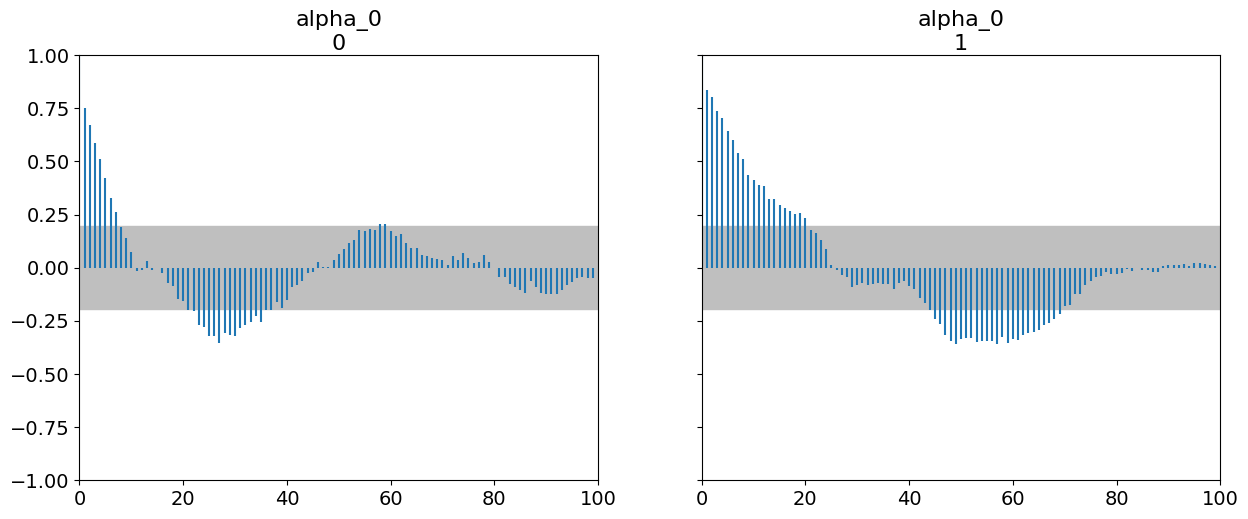

In [ ]:
az.plot_autocorr(idata, var_names=["alpha_0"])